# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.8542914992445194 -3.0738153227469995
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, reward, training

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward, training): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss_p = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward/rate = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-Qs_label))
    # g_loss_q = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                   labels=tf.nn.sigmoid(Qs_label)))
    g_loss = g_loss_p + g_loss_q
    return actions_logits, Qs_logits, g_loss, d_loss, g_loss_p, g_loss_q

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss_p, self.g_loss_q = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs, 
            training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # success criteria
                success_rate = total_reward/500 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, g_loss_p, g_loss_q, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                             model.g_loss_p, model.g_loss_q, 
                                                             model.g_opt, model.d_opt],
                                                            feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.reward: success_rate,
                                                                         model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'stdR:{:.4f}'.format(np.std(episodes_total_reward)),
              'glossP:{:.4f}'.format(g_loss_p),
              'glossQ:{:.4f}'.format(g_loss_q),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:8.0000 stdR:0.0000 glossP:0.0048 glossQ:0.2782 gloss:0.2829 dloss:0.7553
Episode:1 meanR:9.0000 stdR:1.0000 glossP:0.0055 glossQ:0.2708 gloss:0.2763 dloss:0.7352
Episode:2 meanR:15.3333 stdR:8.9938 glossP:0.0158 glossQ:0.2437 gloss:0.2595 dloss:0.6777
Episode:3 meanR:25.2500 stdR:18.8597 glossP:0.0301 glossQ:0.2356 gloss:0.2657 dloss:0.6665
Episode:4 meanR:26.6000 stdR:17.0833 glossP:0.0128 glossQ:0.2222 gloss:0.2350 dloss:0.6335
Episode:5 meanR:28.1667 stdR:15.9835 glossP:0.0112 glossQ:0.2114 gloss:0.2226 dloss:0.6113
Episode:6 meanR:30.1429 stdR:15.5695 glossP:0.0089 glossQ:0.1995 gloss:0.2084 dloss:0.5888
Episode:7 meanR:32.2500 stdR:15.5945 glossP:0.0061 glossQ:0.1918 gloss:0.1979 dloss:0.5738
Episode:8 meanR:32.3333 stdR:14.7045 glossP:0.0057 glossQ:0.1954 gloss:0.2010 dloss:0.5722
Episode:9 meanR:31.8000 stdR:14.0414 glossP:0.0029 glossQ:0.1924 gloss:0.1953 dloss:0.5526
Episode:10 meanR:31.2727 stdR:13.4914 glossP:0.0014 glossQ:0.1905 gloss:0.1919 dloss:0.5394
Epi

Episode:91 meanR:23.9891 stdR:28.4756 glossP:-0.0424 glossQ:0.2156 gloss:0.1731 dloss:0.2521
Episode:92 meanR:23.9032 stdR:28.3341 glossP:-0.0287 glossQ:0.2682 gloss:0.2395 dloss:0.2298
Episode:93 meanR:23.8085 stdR:28.1977 glossP:-0.0269 glossQ:0.2733 gloss:0.2464 dloss:0.2260
Episode:94 meanR:23.6632 stdR:28.0843 glossP:-0.0177 glossQ:0.4970 gloss:0.4792 dloss:0.2029
Episode:95 meanR:23.5104 stdR:27.9773 glossP:-0.0156 glossQ:0.6706 gloss:0.6550 dloss:0.1909
Episode:96 meanR:23.3711 stdR:27.8661 glossP:-0.0172 glossQ:0.5784 gloss:0.5611 dloss:0.1849
Episode:97 meanR:23.2449 stdR:27.7515 glossP:-0.0194 glossQ:0.6059 gloss:0.5865 dloss:0.1766
Episode:98 meanR:23.1111 stdR:27.6427 glossP:-0.0162 glossQ:0.6518 gloss:0.6356 dloss:0.1719
Episode:99 meanR:22.9800 stdR:27.5351 glossP:-0.0155 glossQ:0.6849 gloss:0.6694 dloss:0.1674
Episode:100 meanR:23.0000 stdR:27.5249 glossP:-0.0152 glossQ:0.7269 gloss:0.7117 dloss:0.1596
Episode:101 meanR:23.0000 stdR:27.5249 glossP:-0.0148 glossQ:0.7802 g

Episode:187 meanR:10.3300 stdR:4.5212 glossP:-0.0158 glossQ:2.3638 gloss:2.3480 dloss:0.0915
Episode:188 meanR:10.0200 stdR:3.3999 glossP:-0.0159 glossQ:2.2872 gloss:2.2713 dloss:0.0915
Episode:189 meanR:9.8200 stdR:2.7436 glossP:-0.0167 glossQ:2.3029 gloss:2.2861 dloss:0.0996
Episode:190 meanR:9.6000 stdR:1.7321 glossP:-0.0156 glossQ:2.3212 gloss:2.3056 dloss:0.0915
Episode:191 meanR:9.4600 stdR:1.0901 glossP:-0.0155 glossQ:2.3048 gloss:2.2893 dloss:0.0917
Episode:192 meanR:9.4000 stdR:0.8718 glossP:-0.0176 glossQ:2.2583 gloss:2.2408 dloss:0.0995
Episode:193 meanR:9.3400 stdR:0.6666 glossP:-0.0164 glossQ:2.2687 gloss:2.2522 dloss:0.0915
Episode:194 meanR:9.3300 stdR:0.6642 glossP:-0.0172 glossQ:2.2859 gloss:2.2686 dloss:0.0913
Episode:195 meanR:9.3400 stdR:0.6666 glossP:-0.0189 glossQ:2.2010 gloss:2.1821 dloss:0.0994
Episode:196 meanR:9.3300 stdR:0.6642 glossP:-0.0178 glossQ:2.2920 gloss:2.2742 dloss:0.0913
Episode:197 meanR:9.3200 stdR:0.6462 glossP:-0.0194 glossQ:2.2017 gloss:2.1823

Episode:278 meanR:12.5600 stdR:9.3320 glossP:-0.0876 glossQ:0.6230 gloss:0.5354 dloss:0.1764
Episode:279 meanR:12.7400 stdR:9.4537 glossP:-0.1143 glossQ:0.4829 gloss:0.3686 dloss:0.2226
Episode:280 meanR:12.8500 stdR:9.4851 glossP:-0.0828 glossQ:0.5666 gloss:0.4838 dloss:0.1752
Episode:281 meanR:13.0100 stdR:9.5703 glossP:-0.1017 glossQ:0.4829 gloss:0.3812 dloss:0.2071
Episode:282 meanR:13.1700 stdR:9.6520 glossP:-0.0990 glossQ:0.4522 gloss:0.3532 dloss:0.2060
Episode:283 meanR:13.3400 stdR:9.7439 glossP:-0.1009 glossQ:0.4025 gloss:0.3016 dloss:0.2121
Episode:284 meanR:13.4100 stdR:9.7520 glossP:-0.0643 glossQ:0.6048 gloss:0.5405 dloss:0.1566
Episode:285 meanR:13.5000 stdR:9.7524 glossP:-0.0623 glossQ:0.5692 gloss:0.5070 dloss:0.1578
Episode:286 meanR:13.6200 stdR:9.7701 glossP:-0.0730 glossQ:0.5289 gloss:0.4559 dloss:0.1757
Episode:287 meanR:13.8600 stdR:9.9469 glossP:-0.1137 glossQ:0.2848 gloss:0.1712 dloss:0.2447
Episode:288 meanR:14.0400 stdR:10.0199 glossP:-0.0906 glossQ:0.3821 gl

Episode:373 meanR:15.1100 stdR:8.8746 glossP:-0.0255 glossQ:2.3181 gloss:2.2926 dloss:0.0913
Episode:374 meanR:14.7400 stdR:8.3338 glossP:-0.0257 glossQ:2.3263 gloss:2.3006 dloss:0.0913
Episode:375 meanR:14.4900 stdR:8.0938 glossP:-0.0293 glossQ:2.3009 gloss:2.2717 dloss:0.0995
Episode:376 meanR:14.1100 stdR:7.3714 glossP:-0.0295 glossQ:2.2688 gloss:2.2392 dloss:0.0994
Episode:377 meanR:13.8900 stdR:7.1901 glossP:-0.0264 glossQ:2.3078 gloss:2.2814 dloss:0.0912
Episode:378 meanR:13.7700 stdR:7.1706 glossP:-0.0268 glossQ:2.2537 gloss:2.2269 dloss:0.0911
Episode:379 meanR:13.6000 stdR:7.0314 glossP:-0.0338 glossQ:2.3748 gloss:2.3411 dloss:0.1085
Episode:380 meanR:13.4800 stdR:7.0064 glossP:-0.0274 glossQ:2.2641 gloss:2.2367 dloss:0.0912
Episode:381 meanR:13.3200 stdR:6.9006 glossP:-0.0310 glossQ:2.3056 gloss:2.2745 dloss:0.0995
Episode:382 meanR:13.1400 stdR:6.8015 glossP:-0.0244 glossQ:2.3349 gloss:2.3105 dloss:0.0833
Episode:383 meanR:12.9600 stdR:6.6692 glossP:-0.0280 glossQ:2.3194 glo

Episode:466 meanR:16.3700 stdR:17.2636 glossP:-0.0334 glossQ:3.0621 gloss:3.0288 dloss:0.0941
Episode:467 meanR:16.3600 stdR:17.2670 glossP:-0.0384 glossQ:3.1136 gloss:3.0753 dloss:0.1034
Episode:468 meanR:16.3500 stdR:17.2710 glossP:-0.0339 glossQ:3.0574 gloss:3.0235 dloss:0.0939
Episode:469 meanR:16.3500 stdR:17.2710 glossP:-0.0394 glossQ:3.2659 gloss:3.2266 dloss:0.1038
Episode:470 meanR:16.3500 stdR:17.2710 glossP:-0.0349 glossQ:3.2411 gloss:3.2062 dloss:0.0940
Episode:471 meanR:16.3400 stdR:17.2750 glossP:-0.0352 glossQ:3.2458 gloss:3.2106 dloss:0.0940
Episode:472 meanR:16.3500 stdR:17.2704 glossP:-0.0356 glossQ:3.3555 gloss:3.3199 dloss:0.0942
Episode:473 meanR:16.3600 stdR:17.2665 glossP:-0.0409 glossQ:3.3553 gloss:3.3144 dloss:0.1040
Episode:474 meanR:16.3700 stdR:17.2625 glossP:-0.0414 glossQ:3.4542 gloss:3.4128 dloss:0.1044
Episode:475 meanR:16.3500 stdR:17.2710 glossP:-0.0317 glossQ:3.3492 gloss:3.3176 dloss:0.0847
Episode:476 meanR:16.3600 stdR:17.2676 glossP:-0.0471 glossQ

Episode:557 meanR:15.2000 stdR:13.3192 glossP:-0.0307 glossQ:2.1442 gloss:2.1135 dloss:0.0944
Episode:558 meanR:15.1900 stdR:13.3234 glossP:-0.0306 glossQ:2.1482 gloss:2.1176 dloss:0.0944
Episode:559 meanR:15.2400 stdR:13.3132 glossP:-0.0543 glossQ:1.2576 gloss:1.2033 dloss:0.1382
Episode:560 meanR:15.8000 stdR:14.1880 glossP:-0.2642 glossQ:0.1831 gloss:-0.0811 dloss:0.4444
Episode:561 meanR:16.0900 stdR:14.3618 glossP:-0.1584 glossQ:0.3032 gloss:0.1448 dloss:0.2859
Episode:562 meanR:16.2600 stdR:14.3893 glossP:-0.1052 glossQ:0.8455 gloss:0.7404 dloss:0.2177
Episode:563 meanR:16.2700 stdR:14.3846 glossP:-0.0371 glossQ:2.2967 gloss:2.2596 dloss:0.1036
Episode:564 meanR:16.2900 stdR:14.3745 glossP:-0.0360 glossQ:1.7570 gloss:1.7211 dloss:0.1046
Episode:565 meanR:16.3600 stdR:14.3558 glossP:-0.0597 glossQ:1.0671 gloss:1.0074 dloss:0.1451
Episode:566 meanR:16.4100 stdR:14.3388 glossP:-0.0517 glossQ:1.2132 gloss:1.1615 dloss:0.1321
Episode:567 meanR:16.4000 stdR:14.3436 glossP:-0.0304 gloss

Episode:653 meanR:18.7300 stdR:14.2344 glossP:-0.0356 glossQ:1.8322 gloss:1.7966 dloss:0.1040
Episode:654 meanR:18.7200 stdR:14.2415 glossP:-0.0274 glossQ:1.9507 gloss:1.9232 dloss:0.0909
Episode:655 meanR:18.7400 stdR:14.2279 glossP:-0.0363 glossQ:1.9192 gloss:1.8828 dloss:0.1033
Episode:656 meanR:18.7400 stdR:14.2279 glossP:-0.0322 glossQ:1.9419 gloss:1.9097 dloss:0.0963
Episode:657 meanR:18.7300 stdR:14.2351 glossP:-0.0292 glossQ:2.3324 gloss:2.3032 dloss:0.0865
Episode:658 meanR:18.7400 stdR:14.2286 glossP:-0.0382 glossQ:1.8187 gloss:1.7805 dloss:0.1012
Episode:659 meanR:18.7700 stdR:14.2238 glossP:-0.0735 glossQ:0.9866 gloss:0.9131 dloss:0.1567
Episode:660 meanR:18.2200 stdR:13.4689 glossP:-0.0379 glossQ:2.2303 gloss:2.1924 dloss:0.1007
Episode:661 meanR:17.9100 stdR:13.3432 glossP:-0.0295 glossQ:2.2136 gloss:2.1842 dloss:0.0873
Episode:662 meanR:17.7300 stdR:13.3408 glossP:-0.0344 glossQ:2.2177 gloss:2.1833 dloss:0.0938
Episode:663 meanR:17.7200 stdR:13.3470 glossP:-0.0347 glossQ

Episode:746 meanR:17.1700 stdR:13.3664 glossP:-0.0298 glossQ:2.1891 gloss:2.1593 dloss:0.0889
Episode:747 meanR:17.2900 stdR:13.3554 glossP:-0.0879 glossQ:0.7699 gloss:0.6820 dloss:0.1825
Episode:748 meanR:17.5600 stdR:13.4375 glossP:-0.1395 glossQ:0.3690 gloss:0.2295 dloss:0.2611
Episode:749 meanR:17.6800 stdR:13.4141 glossP:-0.0826 glossQ:0.6008 gloss:0.5181 dloss:0.1746
Episode:750 meanR:18.1200 stdR:13.8689 glossP:-0.2232 glossQ:0.4921 gloss:0.2690 dloss:0.3911
Episode:751 meanR:18.1800 stdR:13.8422 glossP:-0.0573 glossQ:0.9368 gloss:0.8795 dloss:0.1367
Episode:752 meanR:18.1900 stdR:13.8360 glossP:-0.0360 glossQ:1.8428 gloss:1.8068 dloss:0.1018
Episode:753 meanR:18.1900 stdR:13.8360 glossP:-0.0356 glossQ:1.8370 gloss:1.8014 dloss:0.1020
Episode:754 meanR:18.3200 stdR:13.8006 glossP:-0.0808 glossQ:0.5891 gloss:0.5083 dloss:0.1747
Episode:755 meanR:18.6700 stdR:14.0272 glossP:-0.1763 glossQ:0.2798 gloss:0.1035 dloss:0.3195
Episode:756 meanR:19.1400 stdR:14.4755 glossP:-0.2193 glossQ

Episode:837 meanR:21.9600 stdR:15.2800 glossP:-0.0361 glossQ:2.0718 gloss:2.0357 dloss:0.1025
Episode:838 meanR:21.7500 stdR:15.2986 glossP:-0.0363 glossQ:2.0835 gloss:2.0473 dloss:0.1025
Episode:839 meanR:21.6300 stdR:15.3510 glossP:-0.0329 glossQ:2.1450 gloss:2.1121 dloss:0.0954
Episode:840 meanR:21.5100 stdR:15.4023 glossP:-0.0339 glossQ:2.1915 gloss:2.1576 dloss:0.0951
Episode:841 meanR:21.6300 stdR:15.3510 glossP:-0.0831 glossQ:0.7447 gloss:0.6616 dloss:0.1756
Episode:842 meanR:21.7800 stdR:15.3001 glossP:-0.0916 glossQ:0.4350 gloss:0.3434 dloss:0.1928
Episode:843 meanR:21.7500 stdR:15.3221 glossP:-0.0311 glossQ:1.6804 gloss:1.6493 dloss:0.1006
Episode:844 meanR:21.5900 stdR:15.3708 glossP:-0.0312 glossQ:1.7164 gloss:1.6852 dloss:0.1001
Episode:845 meanR:21.5800 stdR:15.3793 glossP:-0.0269 glossQ:1.7656 gloss:1.7387 dloss:0.0945
Episode:846 meanR:21.6000 stdR:15.3629 glossP:-0.0361 glossQ:1.7315 gloss:1.6954 dloss:0.1053
Episode:847 meanR:21.4700 stdR:15.4139 glossP:-0.0317 glossQ

Episode:925 meanR:17.6500 stdR:17.3674 glossP:-0.1164 glossQ:0.4435 gloss:0.3271 dloss:0.2348
Episode:926 meanR:17.7200 stdR:17.4672 glossP:-0.1746 glossQ:0.3015 gloss:0.1269 dloss:0.3219
Episode:927 meanR:17.6900 stdR:17.4572 glossP:-0.0822 glossQ:0.6946 gloss:0.6124 dloss:0.1829
Episode:928 meanR:17.7600 stdR:17.4803 glossP:-0.1027 glossQ:0.4251 gloss:0.3224 dloss:0.2108
Episode:929 meanR:18.0300 stdR:17.5513 glossP:-0.1373 glossQ:0.3438 gloss:0.2064 dloss:0.2638
Episode:930 meanR:18.1900 stdR:17.5321 glossP:-0.0913 glossQ:0.5094 gloss:0.4182 dloss:0.1932
Episode:931 meanR:18.2500 stdR:17.5142 glossP:-0.0602 glossQ:0.7226 gloss:0.6624 dloss:0.1448
Episode:932 meanR:18.3300 stdR:17.4855 glossP:-0.0595 glossQ:0.7437 gloss:0.6842 dloss:0.1452
Episode:933 meanR:18.4100 stdR:17.4609 glossP:-0.0633 glossQ:0.6101 gloss:0.5469 dloss:0.1514
Episode:934 meanR:18.5600 stdR:17.4438 glossP:-0.0879 glossQ:0.4894 gloss:0.4015 dloss:0.1935
Episode:935 meanR:18.6400 stdR:17.4135 glossP:-0.0593 glossQ

Episode:1015 meanR:19.0700 stdR:16.0911 glossP:-0.0648 glossQ:0.6739 gloss:0.6091 dloss:0.1505
Episode:1016 meanR:18.9800 stdR:16.0941 glossP:-0.0529 glossQ:0.7901 gloss:0.7372 dloss:0.1321
Episode:1017 meanR:18.9600 stdR:16.0916 glossP:-0.0769 glossQ:1.0503 gloss:0.9734 dloss:0.1732
Episode:1018 meanR:18.9300 stdR:16.0961 glossP:-0.0568 glossQ:0.7023 gloss:0.6455 dloss:0.1383
Episode:1019 meanR:18.8900 stdR:16.1034 glossP:-0.0541 glossQ:0.8131 gloss:0.7591 dloss:0.1312
Episode:1020 meanR:18.8400 stdR:16.0858 glossP:-0.0863 glossQ:0.9308 gloss:0.8445 dloss:0.1857
Episode:1021 meanR:18.7500 stdR:16.0258 glossP:-0.0987 glossQ:0.7683 gloss:0.6696 dloss:0.2039
Episode:1022 meanR:18.7800 stdR:16.0179 glossP:-0.0655 glossQ:0.7534 gloss:0.6879 dloss:0.1424
Episode:1023 meanR:18.8500 stdR:15.9902 glossP:-0.0661 glossQ:0.9295 gloss:0.8633 dloss:0.1427
Episode:1024 meanR:18.9300 stdR:15.9607 glossP:-0.0714 glossQ:0.9853 gloss:0.9138 dloss:0.1497
Episode:1025 meanR:18.7700 stdR:15.9191 glossP:-0.

Episode:1104 meanR:28.4100 stdR:22.9587 glossP:-0.0797 glossQ:0.4767 gloss:0.3970 dloss:0.1753
Episode:1105 meanR:28.7200 stdR:22.9173 glossP:-0.1575 glossQ:0.4523 gloss:0.2948 dloss:0.2974
Episode:1106 meanR:28.7200 stdR:22.9173 glossP:-0.0360 glossQ:2.3689 gloss:2.3329 dloss:0.0967
Episode:1107 meanR:28.6700 stdR:22.9526 glossP:-0.0415 glossQ:2.3023 gloss:2.2608 dloss:0.1038
Episode:1108 meanR:28.5800 stdR:22.9883 glossP:-0.0592 glossQ:0.7302 gloss:0.6710 dloss:0.1373
Episode:1109 meanR:28.7000 stdR:22.9693 glossP:-0.1162 glossQ:0.3528 gloss:0.2366 dloss:0.2344
Episode:1110 meanR:28.8500 stdR:22.9349 glossP:-0.1155 glossQ:0.3405 gloss:0.2250 dloss:0.2337
Episode:1111 meanR:28.7900 stdR:22.9788 glossP:-0.0318 glossQ:1.6531 gloss:1.6213 dloss:0.1025
Episode:1112 meanR:28.7700 stdR:22.9943 glossP:-0.0370 glossQ:1.6444 gloss:1.6074 dloss:0.1074
Episode:1113 meanR:29.8400 stdR:24.6210 glossP:-0.4401 glossQ:0.0942 gloss:-0.3459 dloss:0.7238
Episode:1114 meanR:29.8400 stdR:24.6210 glossP:-0

Episode:1192 meanR:19.1000 stdR:16.8805 glossP:-0.0991 glossQ:0.5183 gloss:0.4192 dloss:0.1994
Episode:1193 meanR:19.0600 stdR:16.8925 glossP:-0.0473 glossQ:1.0053 gloss:0.9580 dloss:0.1171
Episode:1194 meanR:18.7000 stdR:16.5889 glossP:-0.0603 glossQ:0.8673 gloss:0.8070 dloss:0.1364
Episode:1195 meanR:18.3600 stdR:16.3521 glossP:-0.0514 glossQ:1.0018 gloss:0.9503 dloss:0.1239
Episode:1196 meanR:18.1700 stdR:16.2678 glossP:-0.0648 glossQ:0.7446 gloss:0.6798 dloss:0.1427
Episode:1197 meanR:18.2500 stdR:16.2520 glossP:-0.0771 glossQ:0.6725 gloss:0.5954 dloss:0.1619
Episode:1198 meanR:18.3100 stdR:16.2288 glossP:-0.0606 glossQ:0.8757 gloss:0.8151 dloss:0.1363
Episode:1199 meanR:18.3700 stdR:16.2053 glossP:-0.0606 glossQ:0.8928 gloss:0.8323 dloss:0.1364
Episode:1200 meanR:18.5300 stdR:16.1910 glossP:-0.0997 glossQ:0.5221 gloss:0.4224 dloss:0.1995
Episode:1201 meanR:18.7700 stdR:16.2110 glossP:-0.1260 glossQ:0.3862 gloss:0.2602 dloss:0.2412
Episode:1202 meanR:18.9100 stdR:16.3414 glossP:-0.

Episode:1279 meanR:23.7900 stdR:27.7483 glossP:-0.2244 glossQ:0.2550 gloss:0.0307 dloss:0.4022
Episode:1280 meanR:24.2100 stdR:27.8389 glossP:-0.1911 glossQ:0.2514 gloss:0.0603 dloss:0.3486
Episode:1281 meanR:24.5600 stdR:27.8781 glossP:-0.1664 glossQ:0.2613 gloss:0.0949 dloss:0.3147
Episode:1282 meanR:24.8900 stdR:27.8872 glossP:-0.1497 glossQ:0.2589 gloss:0.1092 dloss:0.2953
Episode:1283 meanR:24.9600 stdR:27.9138 glossP:-0.1386 glossQ:0.2731 gloss:0.1345 dloss:0.2791
Episode:1284 meanR:25.2700 stdR:27.9180 glossP:-0.1425 glossQ:0.3480 gloss:0.2055 dloss:0.2898
Episode:1285 meanR:25.6000 stdR:27.9188 glossP:-0.1468 glossQ:0.2576 gloss:0.1108 dloss:0.2934
Episode:1286 meanR:25.8400 stdR:28.0755 glossP:-0.1883 glossQ:0.1561 gloss:-0.0323 dloss:0.3631
Episode:1287 meanR:25.7400 stdR:28.0997 glossP:-0.0426 glossQ:0.4820 gloss:0.4394 dloss:0.1506
Episode:1288 meanR:25.6200 stdR:28.1154 glossP:-0.0500 glossQ:0.5960 gloss:0.5460 dloss:0.1577
Episode:1289 meanR:25.3600 stdR:28.1292 glossP:-0

Episode:1366 meanR:36.5800 stdR:31.9306 glossP:-0.3878 glossQ:0.1101 gloss:-0.2776 dloss:0.6572
Episode:1367 meanR:37.3100 stdR:32.2616 glossP:-0.3138 glossQ:0.4135 gloss:0.0997 dloss:0.5612
Episode:1368 meanR:38.0200 stdR:32.5429 glossP:-0.2927 glossQ:0.4040 gloss:0.1113 dloss:0.5386
Episode:1369 meanR:38.9300 stdR:33.5623 glossP:-0.3954 glossQ:0.1104 gloss:-0.2850 dloss:0.6853
Episode:1370 meanR:39.1300 stdR:33.4845 glossP:-0.1091 glossQ:0.2241 gloss:0.1150 dloss:0.2603
Episode:1371 meanR:37.4400 stdR:30.2375 glossP:-0.0484 glossQ:0.6261 gloss:0.5777 dloss:0.1502
Episode:1372 meanR:36.7400 stdR:29.9137 glossP:-0.0507 glossQ:0.5123 gloss:0.4616 dloss:0.1571
Episode:1373 meanR:36.4800 stdR:29.9972 glossP:-0.0434 glossQ:0.5686 gloss:0.5252 dloss:0.1480
Episode:1374 meanR:36.2600 stdR:30.0731 glossP:-0.0465 glossQ:0.5961 gloss:0.5496 dloss:0.1545
Episode:1375 meanR:36.2400 stdR:30.0859 glossP:-0.0505 glossQ:0.5090 gloss:0.4584 dloss:0.1576
Episode:1376 meanR:36.5200 stdR:29.9985 glossP:-

Episode:1453 meanR:43.3500 stdR:28.1845 glossP:-0.1713 glossQ:0.1103 gloss:-0.0610 dloss:0.3762
Episode:1454 meanR:43.1800 stdR:28.3095 glossP:-0.0445 glossQ:0.5767 gloss:0.5321 dloss:0.1470
Episode:1455 meanR:43.2200 stdR:28.2710 glossP:-0.0560 glossQ:0.3075 gloss:0.2515 dloss:0.1724
Episode:1456 meanR:43.3000 stdR:28.1824 glossP:-0.0508 glossQ:0.4917 gloss:0.4408 dloss:0.1582
Episode:1457 meanR:43.3700 stdR:28.1082 glossP:-0.0548 glossQ:0.4296 gloss:0.3749 dloss:0.1628
Episode:1458 meanR:43.5600 stdR:27.9458 glossP:-0.0896 glossQ:0.1954 gloss:0.1058 dloss:0.2268
Episode:1459 meanR:43.8900 stdR:27.7416 glossP:-0.1216 glossQ:0.1116 gloss:-0.0100 dloss:0.2968
Episode:1460 meanR:44.3000 stdR:27.5697 glossP:-0.1427 glossQ:0.0893 gloss:-0.0534 dloss:0.3402
Episode:1461 meanR:44.6800 stdR:27.4386 glossP:-0.1423 glossQ:0.0860 gloss:-0.0563 dloss:0.3447
Episode:1462 meanR:44.7100 stdR:27.4111 glossP:-0.0591 glossQ:0.3504 gloss:0.2913 dloss:0.1940
Episode:1463 meanR:44.9000 stdR:27.2769 glossP

Episode:1539 meanR:40.6500 stdR:25.1616 glossP:-0.1697 glossQ:0.1529 gloss:-0.0168 dloss:0.3265
Episode:1540 meanR:40.3700 stdR:25.0223 glossP:-0.1457 glossQ:0.2523 gloss:0.1065 dloss:0.2807
Episode:1541 meanR:39.5400 stdR:24.5350 glossP:-0.0511 glossQ:0.9964 gloss:0.9453 dloss:0.1250
Episode:1542 meanR:39.5200 stdR:24.5526 glossP:-0.0663 glossQ:0.5985 gloss:0.5322 dloss:0.1506
Episode:1543 meanR:38.8600 stdR:24.3146 glossP:-0.0580 glossQ:0.6306 gloss:0.5726 dloss:0.1392
Episode:1544 meanR:38.8100 stdR:24.3071 glossP:-0.1403 glossQ:0.2953 gloss:0.1549 dloss:0.2839
Episode:1545 meanR:39.1100 stdR:24.1838 glossP:-0.1469 glossQ:0.2133 gloss:0.0664 dloss:0.3015
Episode:1546 meanR:39.5900 stdR:24.5903 glossP:-0.2842 glossQ:0.0770 gloss:-0.2072 dloss:0.5078
Episode:1547 meanR:39.8500 stdR:24.7303 glossP:-0.2105 glossQ:0.1035 gloss:-0.1070 dloss:0.4090
Episode:1548 meanR:40.0500 stdR:24.8276 glossP:-0.1944 glossQ:0.0964 gloss:-0.0980 dloss:0.3883
Episode:1549 meanR:40.2800 stdR:24.9876 glossP

Episode:1627 meanR:38.5600 stdR:24.9613 glossP:-0.0877 glossQ:0.3400 gloss:0.2523 dloss:0.2003
Episode:1628 meanR:38.4500 stdR:25.0405 glossP:-0.0537 glossQ:0.6425 gloss:0.5888 dloss:0.1421
Episode:1629 meanR:38.3000 stdR:25.1354 glossP:-0.0536 glossQ:0.6543 gloss:0.6007 dloss:0.1421
Episode:1630 meanR:38.1900 stdR:25.2130 glossP:-0.0561 glossQ:0.6902 gloss:0.6340 dloss:0.1395
Episode:1631 meanR:38.3100 stdR:25.1546 glossP:-0.1198 glossQ:0.3242 gloss:0.2045 dloss:0.2395
Episode:1632 meanR:39.0100 stdR:25.4957 glossP:-0.3106 glossQ:0.1611 gloss:-0.1494 dloss:0.5347
Episode:1633 meanR:39.3300 stdR:25.3551 glossP:-0.1657 glossQ:0.2995 gloss:0.1338 dloss:0.3098
Episode:1634 meanR:39.3800 stdR:25.3613 glossP:-0.1723 glossQ:0.2602 gloss:0.0879 dloss:0.3161
Episode:1635 meanR:39.3700 stdR:25.3573 glossP:-0.1853 glossQ:0.3014 gloss:0.1161 dloss:0.3393
Episode:1636 meanR:40.1300 stdR:25.6627 glossP:-0.3256 glossQ:0.1588 gloss:-0.1667 dloss:0.5527
Episode:1637 meanR:40.3500 stdR:25.7804 glossP:-

Episode:1715 meanR:44.9100 stdR:26.1985 glossP:-0.0968 glossQ:0.2551 gloss:0.1583 dloss:0.2475
Episode:1716 meanR:44.9600 stdR:26.1557 glossP:-0.0733 glossQ:0.3344 gloss:0.2611 dloss:0.2100
Episode:1717 meanR:44.9700 stdR:26.1505 glossP:-0.0953 glossQ:0.2944 gloss:0.1991 dloss:0.2429
Episode:1718 meanR:44.8900 stdR:26.1839 glossP:-0.0954 glossQ:0.1937 gloss:0.0983 dloss:0.2320
Episode:1719 meanR:44.5500 stdR:26.3744 glossP:-0.0442 glossQ:0.6066 gloss:0.5624 dloss:0.1361
Episode:1720 meanR:44.4700 stdR:26.3668 glossP:-0.1372 glossQ:0.1414 gloss:0.0042 dloss:0.2961
Episode:1721 meanR:44.5700 stdR:26.3573 glossP:-0.1472 glossQ:0.1266 gloss:-0.0206 dloss:0.3150
Episode:1722 meanR:44.4600 stdR:26.3615 glossP:-0.1286 glossQ:0.2833 gloss:0.1548 dloss:0.2706
Episode:1723 meanR:44.2500 stdR:26.5113 glossP:-0.0546 glossQ:0.7403 gloss:0.6857 dloss:0.1417
Episode:1724 meanR:44.3500 stdR:26.4686 glossP:-0.1288 glossQ:0.3162 gloss:0.1874 dloss:0.2711
Episode:1725 meanR:44.4300 stdR:26.4402 glossP:-0

Episode:1801 meanR:47.1800 stdR:34.5318 glossP:-0.0497 glossQ:0.3720 gloss:0.3223 dloss:0.1821
Episode:1802 meanR:46.9800 stdR:34.5555 glossP:-0.0937 glossQ:0.2481 gloss:0.1544 dloss:0.2494
Episode:1803 meanR:47.0100 stdR:34.5446 glossP:-0.1116 glossQ:0.1599 gloss:0.0482 dloss:0.2618
Episode:1804 meanR:47.1000 stdR:34.5067 glossP:-0.1086 glossQ:0.2103 gloss:0.1018 dloss:0.2661
Episode:1805 meanR:46.6600 stdR:34.4541 glossP:-0.0873 glossQ:0.2659 gloss:0.1786 dloss:0.2271
Episode:1806 meanR:45.5400 stdR:33.7347 glossP:-0.0408 glossQ:0.7543 gloss:0.7134 dloss:0.1294
Episode:1807 meanR:45.3300 stdR:33.8275 glossP:-0.0658 glossQ:0.3248 gloss:0.2590 dloss:0.1783
Episode:1808 meanR:45.5300 stdR:33.7539 glossP:-0.1342 glossQ:0.2006 gloss:0.0664 dloss:0.2937
Episode:1809 meanR:45.6300 stdR:33.6989 glossP:-0.0995 glossQ:0.2408 gloss:0.1413 dloss:0.2402
Episode:1810 meanR:45.6200 stdR:33.7025 glossP:-0.1071 glossQ:0.3118 gloss:0.2048 dloss:0.2445
Episode:1811 meanR:45.6300 stdR:33.7063 glossP:-0.

Episode:1887 meanR:45.7900 stdR:46.2213 glossP:-0.0757 glossQ:0.2564 gloss:0.1807 dloss:0.2077
Episode:1888 meanR:45.2600 stdR:46.1412 glossP:-0.0790 glossQ:0.2861 gloss:0.2071 dloss:0.2122
Episode:1889 meanR:44.7500 stdR:45.9918 glossP:-0.1001 glossQ:0.1933 gloss:0.0933 dloss:0.2461
Episode:1890 meanR:45.0500 stdR:45.9925 glossP:-0.1842 glossQ:0.1115 gloss:-0.0727 dloss:0.3744
Episode:1891 meanR:44.8000 stdR:45.9785 glossP:-0.1049 glossQ:0.1876 gloss:0.0827 dloss:0.2559
Episode:1892 meanR:44.3900 stdR:45.8275 glossP:-0.1240 glossQ:0.1619 gloss:0.0379 dloss:0.2841
Episode:1893 meanR:44.5700 stdR:45.8138 glossP:-0.1592 glossQ:0.1689 gloss:0.0097 dloss:0.3289
Episode:1894 meanR:44.6100 stdR:45.8081 glossP:-0.1253 glossQ:0.2051 gloss:0.0798 dloss:0.2793
Episode:1895 meanR:44.6100 stdR:45.8081 glossP:-0.1489 glossQ:0.1661 gloss:0.0172 dloss:0.3137
Episode:1896 meanR:44.8700 stdR:45.7016 glossP:-0.1231 glossQ:0.2298 gloss:0.1067 dloss:0.2744
Episode:1897 meanR:45.2000 stdR:45.5965 glossP:-0

Episode:1974 meanR:58.5500 stdR:42.0486 glossP:-0.2467 glossQ:0.0760 gloss:-0.1707 dloss:0.5424
Episode:1975 meanR:59.0500 stdR:42.2527 glossP:-0.2338 glossQ:0.0802 gloss:-0.1537 dloss:0.5215
Episode:1976 meanR:58.7900 stdR:41.8068 glossP:-0.2609 glossQ:0.0625 gloss:-0.1984 dloss:0.5779
Episode:1977 meanR:58.8900 stdR:41.9885 glossP:-0.3373 glossQ:0.0741 gloss:-0.2631 dloss:0.6741
Episode:1978 meanR:59.3000 stdR:42.3909 glossP:-0.2527 glossQ:0.0717 gloss:-0.1809 dloss:0.5822
Episode:1979 meanR:60.2300 stdR:42.6040 glossP:-0.2769 glossQ:0.0800 gloss:-0.1968 dloss:0.5815
Episode:1980 meanR:61.7400 stdR:43.7412 glossP:-0.3903 glossQ:0.0709 gloss:-0.3193 dloss:0.7711
Episode:1981 meanR:62.2300 stdR:43.5786 glossP:-0.1470 glossQ:0.0879 gloss:-0.0590 dloss:0.4146
Episode:1982 meanR:63.2700 stdR:43.7988 glossP:-0.2427 glossQ:0.0710 gloss:-0.1717 dloss:0.5834
Episode:1983 meanR:64.1800 stdR:43.8149 glossP:-0.2369 glossQ:0.0735 gloss:-0.1633 dloss:0.5461
Episode:1984 meanR:65.7500 stdR:44.9307 

Episode:2062 meanR:72.5200 stdR:42.0522 glossP:-0.1040 glossQ:0.2087 gloss:0.1047 dloss:0.2864
Episode:2063 meanR:72.2700 stdR:42.1644 glossP:-0.1043 glossQ:0.1621 gloss:0.0578 dloss:0.2922
Episode:2064 meanR:71.8600 stdR:42.4606 glossP:-0.0573 glossQ:0.2696 gloss:0.2123 dloss:0.1995
Episode:2065 meanR:72.0900 stdR:42.2571 glossP:-0.1217 glossQ:0.1891 gloss:0.0674 dloss:0.3114
Episode:2066 meanR:71.8700 stdR:42.3506 glossP:-0.1177 glossQ:0.1924 gloss:0.0747 dloss:0.2974
Episode:2067 meanR:71.6400 stdR:42.5038 glossP:-0.0907 glossQ:0.1644 gloss:0.0737 dloss:0.2464
Episode:2068 meanR:71.3500 stdR:42.6128 glossP:-0.1178 glossQ:0.1345 gloss:0.0167 dloss:0.2858
Episode:2069 meanR:70.9900 stdR:42.7070 glossP:-0.1193 glossQ:0.1386 gloss:0.0193 dloss:0.2900
Episode:2070 meanR:70.4300 stdR:43.0428 glossP:-0.0480 glossQ:0.3762 gloss:0.3281 dloss:0.1750
Episode:2071 meanR:70.0400 stdR:43.3294 glossP:-0.0531 glossQ:0.3231 gloss:0.2700 dloss:0.1856
Episode:2072 meanR:69.9800 stdR:43.3364 glossP:-0.

Episode:2148 meanR:61.3500 stdR:52.1907 glossP:-0.1755 glossQ:0.0963 gloss:-0.0792 dloss:0.4043
Episode:2149 meanR:61.2500 stdR:52.1414 glossP:-0.1943 glossQ:0.0804 gloss:-0.1139 dloss:0.4517
Episode:2150 meanR:61.1600 stdR:52.0960 glossP:-0.2023 glossQ:0.0796 gloss:-0.1227 dloss:0.4569
Episode:2151 meanR:61.5100 stdR:52.1978 glossP:-0.2299 glossQ:0.0843 gloss:-0.1456 dloss:0.5003
Episode:2152 meanR:61.9900 stdR:52.5392 glossP:-0.3113 glossQ:0.0535 gloss:-0.2578 dloss:0.6180
Episode:2153 meanR:61.4000 stdR:52.4740 glossP:-0.1002 glossQ:0.1720 gloss:0.0718 dloss:0.2765
Episode:2154 meanR:60.8800 stdR:52.3762 glossP:-0.1162 glossQ:0.1557 gloss:0.0396 dloss:0.3069
Episode:2155 meanR:60.5600 stdR:52.3989 glossP:-0.1067 glossQ:0.1684 gloss:0.0617 dloss:0.2897
Episode:2156 meanR:60.8900 stdR:52.3471 glossP:-0.1920 glossQ:0.1074 gloss:-0.0847 dloss:0.4095
Episode:2157 meanR:61.2700 stdR:52.2375 glossP:-0.1748 glossQ:0.1208 gloss:-0.0540 dloss:0.3912
Episode:2158 meanR:61.0000 stdR:52.4111 glo

Episode:2235 meanR:56.7400 stdR:53.4963 glossP:-0.2316 glossQ:0.0595 gloss:-0.1721 dloss:0.5435
Episode:2236 meanR:57.2400 stdR:53.8225 glossP:-0.2477 glossQ:0.0577 gloss:-0.1900 dloss:0.5681
Episode:2237 meanR:57.7800 stdR:53.9877 glossP:-0.2110 glossQ:0.0625 gloss:-0.1485 dloss:0.5118
Episode:2238 meanR:58.3300 stdR:54.0635 glossP:-0.1930 glossQ:0.0672 gloss:-0.1258 dloss:0.4845
Episode:2239 meanR:58.8400 stdR:54.1664 glossP:-0.1948 glossQ:0.0692 gloss:-0.1255 dloss:0.4908
Episode:2240 meanR:58.8100 stdR:54.1660 glossP:-0.1212 glossQ:0.0872 gloss:-0.0341 dloss:0.3652
Episode:2241 meanR:58.9700 stdR:54.1515 glossP:-0.1330 glossQ:0.0821 gloss:-0.0510 dloss:0.3784
Episode:2242 meanR:58.6600 stdR:54.3020 glossP:-0.0391 glossQ:0.2856 gloss:0.2465 dloss:0.2015
Episode:2243 meanR:58.0600 stdR:54.3722 glossP:-0.0527 glossQ:0.2295 gloss:0.1768 dloss:0.2181
Episode:2244 meanR:57.6700 stdR:54.4895 glossP:-0.0520 glossQ:0.2365 gloss:0.1845 dloss:0.2199
Episode:2245 meanR:57.5100 stdR:54.4648 glo

Episode:2321 meanR:66.2600 stdR:79.5625 glossP:-0.2392 glossQ:0.0728 gloss:-0.1664 dloss:0.6641
Episode:2322 meanR:71.1400 stdR:90.3230 glossP:-0.6995 glossQ:0.0628 gloss:-0.6368 dloss:1.5091
Episode:2323 meanR:72.4900 stdR:90.4676 glossP:-0.2202 glossQ:0.0736 gloss:-0.1465 dloss:0.6304
Episode:2324 meanR:72.2700 stdR:90.2714 glossP:-0.2012 glossQ:0.0696 gloss:-0.1315 dloss:0.6087
Episode:2325 meanR:72.4800 stdR:90.3646 glossP:-0.1779 glossQ:0.0723 gloss:-0.1056 dloss:0.5611
Episode:2326 meanR:71.8800 stdR:90.4654 glossP:-0.0384 glossQ:0.1486 gloss:0.1102 dloss:0.3088
Episode:2327 meanR:71.5600 stdR:90.5775 glossP:-0.0346 glossQ:0.1506 gloss:0.1160 dloss:0.2976
Episode:2328 meanR:70.9700 stdR:90.6867 glossP:-0.0357 glossQ:0.1511 gloss:0.1154 dloss:0.3018
Episode:2329 meanR:70.9300 stdR:90.7087 glossP:-0.0274 glossQ:0.1824 gloss:0.1549 dloss:0.2816
Episode:2330 meanR:70.9100 stdR:90.7203 glossP:-0.0251 glossQ:0.1998 gloss:0.1747 dloss:0.2712
Episode:2331 meanR:70.9100 stdR:90.7203 gloss

Episode:2408 meanR:79.2100 stdR:65.9274 glossP:-0.1337 glossQ:0.0835 gloss:-0.0503 dloss:0.4130
Episode:2409 meanR:79.6200 stdR:65.6475 glossP:-0.1020 glossQ:0.0942 gloss:-0.0077 dloss:0.3631
Episode:2410 meanR:79.9900 stdR:65.4143 glossP:-0.1062 glossQ:0.0917 gloss:-0.0145 dloss:0.3688
Episode:2411 meanR:80.3700 stdR:65.2504 glossP:-0.1308 glossQ:0.0808 gloss:-0.0499 dloss:0.4132
Episode:2412 meanR:80.9600 stdR:65.0769 glossP:-0.1655 glossQ:0.0726 gloss:-0.0929 dloss:0.4750
Episode:2413 meanR:81.9100 stdR:64.6972 glossP:-0.1870 glossQ:0.0757 gloss:-0.1113 dloss:0.5114
Episode:2414 meanR:82.6200 stdR:64.2814 glossP:-0.1419 glossQ:0.0981 gloss:-0.0438 dloss:0.4424
Episode:2415 meanR:83.0700 stdR:63.9350 glossP:-0.1000 glossQ:0.1151 gloss:0.0151 dloss:0.3691
Episode:2416 meanR:83.6300 stdR:63.5630 glossP:-0.1221 glossQ:0.1108 gloss:-0.0113 dloss:0.4095
Episode:2417 meanR:83.9600 stdR:63.2805 glossP:-0.0828 glossQ:0.1324 gloss:0.0496 dloss:0.3375
Episode:2418 meanR:85.5000 stdR:63.4814 gl

Episode:2496 meanR:103.1500 stdR:88.0584 glossP:-0.0692 glossQ:0.1301 gloss:0.0609 dloss:0.4760
Episode:2497 meanR:104.0700 stdR:87.6121 glossP:-0.1418 glossQ:0.0963 gloss:-0.0455 dloss:0.5303
Episode:2498 meanR:103.7400 stdR:87.7416 glossP:-0.0434 glossQ:0.1544 gloss:0.1110 dloss:0.4390
Episode:2499 meanR:103.1700 stdR:87.9166 glossP:-0.0501 glossQ:0.1409 gloss:0.0909 dloss:0.4044
Episode:2500 meanR:102.7400 stdR:88.0117 glossP:-0.0605 glossQ:0.1331 gloss:0.0726 dloss:0.4411
Episode:2501 meanR:102.9400 stdR:88.0552 glossP:-0.1638 glossQ:0.0965 gloss:-0.0673 dloss:0.5878
Episode:2502 meanR:103.6200 stdR:88.4460 glossP:-0.2177 glossQ:0.0900 gloss:-0.1277 dloss:0.7099
Episode:2503 meanR:104.4700 stdR:88.9105 glossP:-0.2279 glossQ:0.0874 gloss:-0.1405 dloss:0.7246
Episode:2504 meanR:104.8500 stdR:88.9589 glossP:-0.0222 glossQ:0.1550 gloss:0.1328 dloss:0.6130
Episode:2505 meanR:105.3400 stdR:88.8399 glossP:-0.0546 glossQ:0.1244 gloss:0.0698 dloss:0.5569
Episode:2506 meanR:109.6100 stdR:97.

Episode:2581 meanR:196.0800 stdR:128.2287 glossP:0.1637 glossQ:0.2285 gloss:0.3922 dloss:0.7191
Episode:2582 meanR:195.5400 stdR:127.7384 glossP:0.2174 glossQ:0.2654 gloss:0.4829 dloss:0.6946
Episode:2583 meanR:194.0800 stdR:127.4502 glossP:0.1483 glossQ:0.3162 gloss:0.4645 dloss:0.7535
Episode:2584 meanR:194.0500 stdR:127.4630 glossP:0.1447 glossQ:0.3204 gloss:0.4651 dloss:0.7636
Episode:2585 meanR:197.8100 stdR:130.0640 glossP:0.5989 glossQ:0.3446 gloss:0.9435 dloss:0.5683
Episode:2586 meanR:198.4100 stdR:129.6569 glossP:0.1591 glossQ:0.3378 gloss:0.4968 dloss:0.7782
Episode:2587 meanR:195.8600 stdR:128.3251 glossP:0.1654 glossQ:0.3524 gloss:0.5178 dloss:0.7980
Episode:2588 meanR:196.1900 stdR:128.0767 glossP:0.1232 glossQ:0.3227 gloss:0.4459 dloss:0.7737
Episode:2589 meanR:196.4400 stdR:127.8876 glossP:0.1061 glossQ:0.2996 gloss:0.4057 dloss:0.7481
Episode:2590 meanR:197.5500 stdR:127.5356 glossP:0.2274 glossQ:0.3160 gloss:0.5434 dloss:0.7231
Episode:2591 meanR:198.4600 stdR:127.174

Episode:2671 meanR:243.1600 stdR:182.1101 glossP:-0.0232 glossQ:0.1399 gloss:0.1167 dloss:0.3387
Episode:2672 meanR:238.3400 stdR:181.6264 glossP:-0.0200 glossQ:0.1685 gloss:0.1484 dloss:0.3106
Episode:2673 meanR:233.5600 stdR:180.9659 glossP:-0.0314 glossQ:0.1538 gloss:0.1224 dloss:0.2823
Episode:2674 meanR:228.8300 stdR:180.1196 glossP:-0.0363 glossQ:0.1320 gloss:0.0957 dloss:0.3091
Episode:2675 meanR:224.0500 stdR:179.2001 glossP:-0.0363 glossQ:0.1689 gloss:0.1326 dloss:0.2615
Episode:2676 meanR:220.3800 stdR:179.4807 glossP:-0.0434 glossQ:0.1511 gloss:0.1077 dloss:0.2653
Episode:2677 meanR:216.0900 stdR:179.0915 glossP:-0.0366 glossQ:0.1929 gloss:0.1563 dloss:0.2391
Episode:2678 meanR:211.3500 stdR:177.7825 glossP:-0.0571 glossQ:0.1845 gloss:0.1274 dloss:0.2380
Episode:2679 meanR:209.2500 stdR:178.1518 glossP:-0.1292 glossQ:0.0699 gloss:-0.0593 dloss:0.4260
Episode:2680 meanR:206.3400 stdR:178.7437 glossP:-0.0649 glossQ:0.1987 gloss:0.1338 dloss:0.2241
Episode:2681 meanR:203.7200 s

Episode:2764 meanR:30.1100 stdR:59.4145 glossP:-0.0284 glossQ:4.9300 gloss:4.9016 dloss:0.1118
Episode:2765 meanR:29.9000 stdR:59.4516 glossP:-0.0228 glossQ:4.3394 gloss:4.3166 dloss:0.0980
Episode:2766 meanR:29.7500 stdR:59.4827 glossP:-0.0225 glossQ:3.7805 gloss:3.7580 dloss:0.1065
Episode:2767 meanR:29.5900 stdR:59.5140 glossP:-0.0208 glossQ:3.5134 gloss:3.4926 dloss:0.1055
Episode:2768 meanR:29.4200 stdR:59.5455 glossP:-0.0190 glossQ:3.0949 gloss:3.0759 dloss:0.1043
Episode:2769 meanR:29.2900 stdR:59.5757 glossP:-0.0161 glossQ:2.7271 gloss:2.7110 dloss:0.0957
Episode:2770 meanR:29.2000 stdR:59.5995 glossP:-0.0153 glossQ:2.4984 gloss:2.4832 dloss:0.0961
Episode:2771 meanR:29.0600 stdR:59.6303 glossP:-0.0146 glossQ:2.2799 gloss:2.2653 dloss:0.0973
Episode:2772 meanR:28.9700 stdR:59.6537 glossP:-0.0142 glossQ:2.1699 gloss:2.1557 dloss:0.0980
Episode:2773 meanR:28.8400 stdR:59.6829 glossP:-0.0139 glossQ:2.1172 gloss:2.1033 dloss:0.0977
Episode:2774 meanR:28.6600 stdR:59.7154 glossP:-0.

Episode:2857 meanR:10.0900 stdR:2.8464 glossP:-0.0344 glossQ:2.2801 gloss:2.2457 dloss:0.0924
Episode:2858 meanR:10.0900 stdR:2.8464 glossP:-0.0396 glossQ:2.1932 gloss:2.1536 dloss:0.1005
Episode:2859 meanR:10.0900 stdR:2.8464 glossP:-0.0349 glossQ:2.3652 gloss:2.3303 dloss:0.0921
Episode:2860 meanR:10.0800 stdR:2.8484 glossP:-0.0342 glossQ:2.2613 gloss:2.2270 dloss:0.0926
Episode:2861 meanR:10.0900 stdR:2.8464 glossP:-0.0397 glossQ:2.2162 gloss:2.1766 dloss:0.1004
Episode:2862 meanR:10.1000 stdR:2.8443 glossP:-0.0397 glossQ:2.2105 gloss:2.1708 dloss:0.1003
Episode:2863 meanR:10.0900 stdR:2.8464 glossP:-0.0351 glossQ:2.3403 gloss:2.3052 dloss:0.0921
Episode:2864 meanR:10.0800 stdR:2.8484 glossP:-0.0350 glossQ:2.2918 gloss:2.2568 dloss:0.0924
Episode:2865 meanR:10.0900 stdR:2.8464 glossP:-0.0405 glossQ:2.2548 gloss:2.2143 dloss:0.1002
Episode:2866 meanR:10.0800 stdR:2.8484 glossP:-0.0355 glossQ:2.3327 gloss:2.2972 dloss:0.0921
Episode:2867 meanR:10.0700 stdR:2.8505 glossP:-0.0360 glossQ

Episode:2944 meanR:18.6300 stdR:13.3294 glossP:-0.1417 glossQ:0.4123 gloss:0.2707 dloss:0.2712
Episode:2945 meanR:18.7000 stdR:13.2970 glossP:-0.0595 glossQ:0.5518 gloss:0.4923 dloss:0.1463
Episode:2946 meanR:19.0100 stdR:13.4280 glossP:-0.1527 glossQ:0.3605 gloss:0.2078 dloss:0.2881
Episode:2947 meanR:19.0700 stdR:13.3965 glossP:-0.0609 glossQ:0.8526 gloss:0.7917 dloss:0.1367
Episode:2948 meanR:19.1400 stdR:13.3619 glossP:-0.0641 glossQ:0.7285 gloss:0.6643 dloss:0.1434
Episode:2949 meanR:19.1900 stdR:13.3369 glossP:-0.0581 glossQ:0.9035 gloss:0.8454 dloss:0.1379
Episode:2950 meanR:19.2700 stdR:13.2995 glossP:-0.0672 glossQ:0.6217 gloss:0.5545 dloss:0.1499
Episode:2951 meanR:19.7000 stdR:13.6825 glossP:-0.1985 glossQ:0.2228 gloss:0.0244 dloss:0.3594
Episode:2952 meanR:20.1200 stdR:14.0188 glossP:-0.1927 glossQ:0.2066 gloss:0.0139 dloss:0.3523
Episode:2953 meanR:20.5800 stdR:14.4279 glossP:-0.2074 glossQ:0.1911 gloss:-0.0163 dloss:0.3745
Episode:2954 meanR:21.0400 stdR:14.8114 glossP:-0

Episode:3032 meanR:30.2400 stdR:21.0837 glossP:-0.0610 glossQ:0.6415 gloss:0.5805 dloss:0.1536
Episode:3033 meanR:30.0500 stdR:21.0895 glossP:-0.0685 glossQ:0.3996 gloss:0.3310 dloss:0.1732
Episode:3034 meanR:30.6000 stdR:21.4560 glossP:-0.2383 glossQ:0.1810 gloss:-0.0573 dloss:0.4437
Episode:3035 meanR:31.0400 stdR:21.9463 glossP:-0.2490 glossQ:0.1542 gloss:-0.0948 dloss:0.4661
Episode:3036 meanR:30.9500 stdR:21.9606 glossP:-0.0800 glossQ:0.3737 gloss:0.2937 dloss:0.1893
Episode:3037 meanR:31.4900 stdR:22.7048 glossP:-0.2812 glossQ:0.1250 gloss:-0.1562 dloss:0.5200
Episode:3038 meanR:32.0200 stdR:22.9081 glossP:-0.2020 glossQ:0.1689 gloss:-0.0332 dloss:0.4074
Episode:3039 meanR:32.7100 stdR:23.3299 glossP:-0.2430 glossQ:0.1391 gloss:-0.1038 dloss:0.4729
Episode:3040 meanR:33.3600 stdR:23.7021 glossP:-0.2291 glossQ:0.1325 gloss:-0.0966 dloss:0.4591
Episode:3041 meanR:34.0700 stdR:24.1997 glossP:-0.2463 glossQ:0.1212 gloss:-0.1250 dloss:0.4885
Episode:3042 meanR:34.1500 stdR:24.1431 glo

Episode:3119 meanR:34.6600 stdR:26.5335 glossP:-0.2312 glossQ:0.0802 gloss:-0.1510 dloss:0.5235
Episode:3120 meanR:34.3100 stdR:26.4672 glossP:-0.0809 glossQ:0.4134 gloss:0.3325 dloss:0.1826
Episode:3121 meanR:34.3900 stdR:26.4662 glossP:-0.1401 glossQ:0.3510 gloss:0.2108 dloss:0.2739
Episode:3122 meanR:34.8300 stdR:27.0156 glossP:-0.1994 glossQ:0.0837 gloss:-0.1157 dloss:0.4886
Episode:3123 meanR:34.5500 stdR:26.9916 glossP:-0.0827 glossQ:0.5062 gloss:0.4235 dloss:0.1890
Episode:3124 meanR:34.0500 stdR:26.8113 glossP:-0.0698 glossQ:0.6264 gloss:0.5567 dloss:0.1648
Episode:3125 meanR:33.6900 stdR:26.4854 glossP:-0.1406 glossQ:0.3154 gloss:0.1748 dloss:0.2830
Episode:3126 meanR:34.4200 stdR:27.2581 glossP:-0.2247 glossQ:0.0813 gloss:-0.1434 dloss:0.5237
Episode:3127 meanR:34.4300 stdR:27.2515 glossP:-0.0651 glossQ:0.5689 gloss:0.5038 dloss:0.1517
Episode:3128 meanR:34.6600 stdR:27.1751 glossP:-0.1137 glossQ:0.1839 gloss:0.0702 dloss:0.2718
Episode:3129 meanR:34.6700 stdR:27.1684 glossP:

Episode:3206 meanR:41.0000 stdR:33.0509 glossP:-0.3294 glossQ:0.0991 gloss:-0.2304 dloss:0.6059
Episode:3207 meanR:40.9900 stdR:33.0583 glossP:-0.0571 glossQ:0.7106 gloss:0.6535 dloss:0.1490
Episode:3208 meanR:40.9400 stdR:33.0998 glossP:-0.0397 glossQ:1.1308 gloss:1.0911 dloss:0.1169
Episode:3209 meanR:40.8700 stdR:33.1493 glossP:-0.0494 glossQ:0.7902 gloss:0.7408 dloss:0.1374
Episode:3210 meanR:40.9900 stdR:33.1169 glossP:-0.1106 glossQ:0.1506 gloss:0.0400 dloss:0.2777
Episode:3211 meanR:40.9600 stdR:33.1336 glossP:-0.0676 glossQ:0.3033 gloss:0.2357 dloss:0.1875
Episode:3212 meanR:40.0200 stdR:32.5177 glossP:-0.0580 glossQ:0.8318 gloss:0.7738 dloss:0.1396
Episode:3213 meanR:39.2600 stdR:31.9433 glossP:-0.0815 glossQ:0.2397 gloss:0.1582 dloss:0.2173
Episode:3214 meanR:39.9000 stdR:32.2110 glossP:-0.2351 glossQ:0.0817 gloss:-0.1534 dloss:0.4873
Episode:3215 meanR:39.8100 stdR:32.2706 glossP:-0.0521 glossQ:0.8546 gloss:0.8025 dloss:0.1346
Episode:3216 meanR:39.7300 stdR:32.3246 glossP:-

Episode:3293 meanR:51.0800 stdR:38.3016 glossP:-0.0708 glossQ:0.2337 gloss:0.1629 dloss:0.2074
Episode:3294 meanR:50.7800 stdR:37.9470 glossP:-0.1927 glossQ:0.1119 gloss:-0.0808 dloss:0.4545
Episode:3295 meanR:51.2900 stdR:37.8456 glossP:-0.1662 glossQ:0.0957 gloss:-0.0705 dloss:0.4041
Episode:3296 meanR:51.6000 stdR:37.6736 glossP:-0.1279 glossQ:0.3046 gloss:0.1767 dloss:0.3136
Episode:3297 meanR:52.4400 stdR:37.6954 glossP:-0.2309 glossQ:0.0776 gloss:-0.1533 dloss:0.5054
Episode:3298 meanR:52.5200 stdR:37.8364 glossP:-0.2780 glossQ:0.0635 gloss:-0.2145 dloss:0.6034
Episode:3299 meanR:53.2300 stdR:38.3327 glossP:-0.2600 glossQ:0.0655 gloss:-0.1945 dloss:0.5744
Episode:3300 meanR:54.0600 stdR:38.7174 glossP:-0.2469 glossQ:0.0653 gloss:-0.1816 dloss:0.5632
Episode:3301 meanR:54.7200 stdR:38.9656 glossP:-0.2174 glossQ:0.0747 gloss:-0.1427 dloss:0.5239
Episode:3302 meanR:55.0800 stdR:38.9481 glossP:-0.1624 glossQ:0.0908 gloss:-0.0716 dloss:0.4107
Episode:3303 meanR:55.0800 stdR:38.9481 gl

Episode:3379 meanR:58.3200 stdR:50.5735 glossP:-0.1043 glossQ:0.2974 gloss:0.1931 dloss:0.2402
Episode:3380 meanR:57.8200 stdR:50.5939 glossP:-0.1024 glossQ:0.3421 gloss:0.2397 dloss:0.2350
Episode:3381 meanR:57.7000 stdR:50.5578 glossP:-0.2384 glossQ:0.1835 gloss:-0.0549 dloss:0.4318
Episode:3382 meanR:57.4100 stdR:50.5524 glossP:-0.1464 glossQ:0.2697 gloss:0.1233 dloss:0.3025
Episode:3383 meanR:57.0600 stdR:50.5644 glossP:-0.1264 glossQ:0.2920 gloss:0.1656 dloss:0.2723
Episode:3384 meanR:58.1200 stdR:51.7948 glossP:-0.5342 glossQ:0.0893 gloss:-0.4449 dloss:0.9088
Episode:3385 meanR:58.0000 stdR:51.7857 glossP:-0.1725 glossQ:0.2327 gloss:0.0603 dloss:0.3587
Episode:3386 meanR:62.5500 stdR:67.9191 glossP:-1.3080 glossQ:0.0329 gloss:-1.2751 dloss:2.1554
Episode:3387 meanR:62.7700 stdR:67.8846 glossP:-0.1769 glossQ:0.1771 gloss:0.0002 dloss:0.3858
Episode:3388 meanR:62.2000 stdR:67.9180 glossP:-0.0873 glossQ:0.3293 gloss:0.2420 dloss:0.2369
Episode:3389 meanR:61.7100 stdR:67.8347 glossP:

Episode:3465 meanR:64.0700 stdR:59.1411 glossP:-0.1375 glossQ:0.0837 gloss:-0.0538 dloss:0.4079
Episode:3466 meanR:65.6000 stdR:60.1585 glossP:-0.3663 glossQ:0.0622 gloss:-0.3040 dloss:0.7766
Episode:3467 meanR:66.5200 stdR:60.0351 glossP:-0.2297 glossQ:0.0918 gloss:-0.1379 dloss:0.5302
Episode:3468 meanR:67.2600 stdR:60.0241 glossP:-0.2238 glossQ:0.0762 gloss:-0.1476 dloss:0.5240
Episode:3469 meanR:67.3900 stdR:59.9508 glossP:-0.0880 glossQ:0.1797 gloss:0.0917 dloss:0.3014
Episode:3470 meanR:67.7300 stdR:59.8398 glossP:-0.1419 glossQ:0.1522 gloss:0.0103 dloss:0.3948
Episode:3471 meanR:67.7300 stdR:59.8398 glossP:-0.0275 glossQ:0.4466 gloss:0.4191 dloss:0.1804
Episode:3472 meanR:68.1700 stdR:59.6118 glossP:-0.1270 glossQ:0.1546 gloss:0.0276 dloss:0.3737
Episode:3473 meanR:68.5100 stdR:59.4270 glossP:-0.1069 glossQ:0.1087 gloss:0.0018 dloss:0.3510
Episode:3474 meanR:68.6000 stdR:59.4163 glossP:-0.1380 glossQ:0.1024 gloss:-0.0355 dloss:0.3943
Episode:3475 meanR:68.4600 stdR:59.4741 gloss

Episode:3551 meanR:70.6200 stdR:57.9070 glossP:-0.1147 glossQ:0.0966 gloss:-0.0181 dloss:0.3637
Episode:3552 meanR:70.6700 stdR:57.8982 glossP:-0.1275 glossQ:0.0835 gloss:-0.0440 dloss:0.3841
Episode:3553 meanR:70.5700 stdR:57.9079 glossP:-0.1202 glossQ:0.0911 gloss:-0.0291 dloss:0.3742
Episode:3554 meanR:74.2000 stdR:71.6946 glossP:-1.0494 glossQ:0.0404 gloss:-1.0091 dloss:1.8633
Episode:3555 meanR:74.1700 stdR:71.6865 glossP:-0.2151 glossQ:0.1055 gloss:-0.1096 dloss:0.4903
Episode:3556 meanR:74.0100 stdR:71.7448 glossP:-0.0937 glossQ:0.2107 gloss:0.1170 dloss:0.2955
Episode:3557 meanR:72.6400 stdR:71.4544 glossP:-0.0450 glossQ:0.2430 gloss:0.1980 dloss:0.2187
Episode:3558 meanR:72.3600 stdR:71.6051 glossP:-0.0442 glossQ:0.2386 gloss:0.1944 dloss:0.2211
Episode:3559 meanR:72.1000 stdR:71.7438 glossP:-0.0453 glossQ:0.2009 gloss:0.1556 dloss:0.2301
Episode:3560 meanR:73.8400 stdR:73.4463 glossP:-0.4690 glossQ:0.0518 gloss:-0.4172 dloss:0.9411
Episode:3561 meanR:77.3600 stdR:84.5168 glos

Episode:3637 meanR:76.7200 stdR:83.9548 glossP:-0.1463 glossQ:0.1148 gloss:-0.0315 dloss:0.3879
Episode:3638 meanR:72.0000 stdR:72.5134 glossP:-0.0655 glossQ:0.1762 gloss:0.1107 dloss:0.2473
Episode:3639 meanR:70.9200 stdR:72.0721 glossP:-0.1060 glossQ:0.1240 gloss:0.0181 dloss:0.3223
Episode:3640 meanR:71.1200 stdR:72.0915 glossP:-0.1971 glossQ:0.1090 gloss:-0.0882 dloss:0.4716
Episode:3641 meanR:71.4000 stdR:72.1332 glossP:-0.2097 glossQ:0.1014 gloss:-0.1083 dloss:0.4985
Episode:3642 meanR:71.8400 stdR:72.0012 glossP:-0.1652 glossQ:0.1023 gloss:-0.0629 dloss:0.4138
Episode:3643 meanR:72.2300 stdR:71.8682 glossP:-0.1505 glossQ:0.1178 gloss:-0.0327 dloss:0.3957
Episode:3644 meanR:73.3200 stdR:72.0609 glossP:-0.3403 glossQ:0.0714 gloss:-0.2689 dloss:0.6771
Episode:3645 meanR:72.9000 stdR:72.2362 glossP:-0.0527 glossQ:0.2224 gloss:0.1697 dloss:0.2186
Episode:3646 meanR:73.0800 stdR:72.1215 glossP:-0.0840 glossQ:0.1499 gloss:0.0660 dloss:0.2779
Episode:3647 meanR:73.3800 stdR:72.1122 glos

Episode:3723 meanR:69.7300 stdR:79.9887 glossP:-0.1608 glossQ:0.0730 gloss:-0.0878 dloss:0.5305
Episode:3724 meanR:70.0500 stdR:79.9091 glossP:-0.0999 glossQ:0.0904 gloss:-0.0095 dloss:0.4099
Episode:3725 meanR:74.8600 stdR:90.4701 glossP:-0.7397 glossQ:0.0575 gloss:-0.6822 dloss:1.5406
Episode:3726 meanR:75.8000 stdR:90.3627 glossP:-0.2082 glossQ:0.0841 gloss:-0.1241 dloss:0.5420
Episode:3727 meanR:75.2600 stdR:89.9646 glossP:-0.2247 glossQ:0.0913 gloss:-0.1334 dloss:0.5567
Episode:3728 meanR:75.4200 stdR:89.9302 glossP:-0.1173 glossQ:0.1042 gloss:-0.0131 dloss:0.3929
Episode:3729 meanR:74.7500 stdR:90.1132 glossP:-0.0355 glossQ:0.2524 gloss:0.2169 dloss:0.2201
Episode:3730 meanR:74.3700 stdR:90.2967 glossP:-0.0250 glossQ:0.3919 gloss:0.3669 dloss:0.2000
Episode:3731 meanR:74.0800 stdR:90.4306 glossP:-0.0392 glossQ:0.2401 gloss:0.2010 dloss:0.2172
Episode:3732 meanR:73.6600 stdR:90.5924 glossP:-0.0360 glossQ:0.2151 gloss:0.1792 dloss:0.2303
Episode:3733 meanR:73.9300 stdR:90.5528 glos

Episode:3808 meanR:155.5200 stdR:170.1311 glossP:0.3067 glossQ:0.2420 gloss:0.5487 dloss:0.7174
Episode:3809 meanR:160.4100 stdR:172.9118 glossP:0.3417 glossQ:0.2523 gloss:0.5940 dloss:0.6965
Episode:3810 meanR:165.0800 stdR:175.6916 glossP:0.3377 glossQ:0.2507 gloss:0.5884 dloss:0.6986
Episode:3811 meanR:167.7600 stdR:175.4104 glossP:0.0697 glossQ:0.2014 gloss:0.2711 dloss:0.7244
Episode:3812 meanR:168.6800 stdR:174.9366 glossP:0.0238 glossQ:0.2103 gloss:0.2341 dloss:0.6429
Episode:3813 meanR:169.7000 stdR:174.4099 glossP:-0.0154 glossQ:0.1883 gloss:0.1729 dloss:0.6347
Episode:3814 meanR:170.5100 stdR:173.9374 glossP:-0.0249 glossQ:0.1832 gloss:0.1584 dloss:0.6051
Episode:3815 meanR:170.5700 stdR:173.8976 glossP:0.0194 glossQ:0.2215 gloss:0.2409 dloss:0.6236
Episode:3816 meanR:170.4500 stdR:173.9752 glossP:0.0216 glossQ:0.2295 gloss:0.2511 dloss:0.6346
Episode:3817 meanR:170.4600 stdR:173.9684 glossP:0.0218 glossQ:0.2266 gloss:0.2484 dloss:0.6355
Episode:3818 meanR:170.4600 stdR:173.9

Episode:3894 meanR:217.6000 stdR:149.8849 glossP:-0.0478 glossQ:0.1450 gloss:0.0972 dloss:0.6852
Episode:3895 meanR:218.2000 stdR:149.6930 glossP:-0.0526 glossQ:0.1416 gloss:0.0890 dloss:0.6817
Episode:3896 meanR:219.2000 stdR:149.2736 glossP:-0.0369 glossQ:0.1504 gloss:0.1135 dloss:0.6872
Episode:3897 meanR:220.4900 stdR:149.0890 glossP:-0.0670 glossQ:0.1434 gloss:0.0765 dloss:0.7528
Episode:3898 meanR:221.5000 stdR:148.5971 glossP:-0.0298 glossQ:0.1529 gloss:0.1231 dloss:0.6792
Episode:3899 meanR:223.0500 stdR:148.0351 glossP:-0.0546 glossQ:0.1463 gloss:0.0918 dloss:0.7306
Episode:3900 meanR:225.7600 stdR:148.1283 glossP:-0.1081 glossQ:0.1376 gloss:0.0295 dloss:0.8739
Episode:3901 meanR:228.3800 stdR:148.4275 glossP:-0.0914 glossQ:0.1423 gloss:0.0509 dloss:0.8728
Episode:3902 meanR:230.8700 stdR:148.6936 glossP:-0.0787 glossQ:0.1456 gloss:0.0670 dloss:0.8606
Episode:3903 meanR:231.1900 stdR:148.6268 glossP:-0.0407 glossQ:0.1482 gloss:0.1076 dloss:0.6945
Episode:3904 meanR:231.1900 st

Episode:3981 meanR:318.3300 stdR:157.2859 glossP:0.0872 glossQ:0.2860 gloss:0.3733 dloss:0.7355
Episode:3982 meanR:319.5000 stdR:156.0281 glossP:0.1937 glossQ:0.3338 gloss:0.5275 dloss:0.7452
Episode:3983 meanR:319.7000 stdR:155.7746 glossP:0.0829 glossQ:0.2777 gloss:0.3606 dloss:0.7284
Episode:3984 meanR:319.8900 stdR:155.5423 glossP:0.0923 glossQ:0.2862 gloss:0.3784 dloss:0.7356
Episode:3985 meanR:320.7500 stdR:154.5922 glossP:0.1526 glossQ:0.3256 gloss:0.4782 dloss:0.7566
Episode:3986 meanR:321.0400 stdR:154.1970 glossP:0.0809 glossQ:0.2843 gloss:0.3652 dloss:0.7315
Episode:3987 meanR:323.7100 stdR:152.4753 glossP:0.3730 glossQ:0.3595 gloss:0.7325 dloss:0.6321
Episode:3988 meanR:324.2800 stdR:151.7240 glossP:0.1123 glossQ:0.3000 gloss:0.4123 dloss:0.7419
Episode:3989 meanR:324.6800 stdR:151.6040 glossP:0.2888 glossQ:0.3479 gloss:0.6367 dloss:0.6880
Episode:3990 meanR:323.9900 stdR:152.2029 glossP:0.1231 glossQ:0.3107 gloss:0.4338 dloss:0.7470
Episode:3991 meanR:323.2700 stdR:152.998

Episode:4067 meanR:224.8800 stdR:94.0848 glossP:0.1286 glossQ:0.2676 gloss:0.3962 dloss:0.6841
Episode:4068 meanR:228.4200 stdR:97.6427 glossP:0.2016 glossQ:0.2818 gloss:0.4834 dloss:0.6349
Episode:4069 meanR:231.2900 stdR:99.3226 glossP:0.1765 glossQ:0.2866 gloss:0.4631 dloss:0.6453
Episode:4070 meanR:231.3300 stdR:99.3225 glossP:0.0761 glossQ:0.2613 gloss:0.3374 dloss:0.6987
Episode:4071 meanR:230.2900 stdR:97.0217 glossP:0.1429 glossQ:0.2771 gloss:0.4200 dloss:0.6696
Episode:4072 meanR:227.9700 stdR:93.2449 glossP:0.1019 glossQ:0.2848 gloss:0.3867 dloss:0.6917
Episode:4073 meanR:225.8000 stdR:89.3319 glossP:0.1084 glossQ:0.2932 gloss:0.4016 dloss:0.6861
Episode:4074 meanR:227.8000 stdR:91.0438 glossP:0.1483 glossQ:0.2894 gloss:0.4377 dloss:0.6506
Episode:4075 meanR:229.4000 stdR:90.7516 glossP:0.1097 glossQ:0.2979 gloss:0.4076 dloss:0.6823
Episode:4076 meanR:226.9200 stdR:86.6174 glossP:0.0940 glossQ:0.2939 gloss:0.3879 dloss:0.6969
Episode:4077 meanR:228.1000 stdR:87.8818 glossP:0.

Episode:4154 meanR:261.4100 stdR:91.2159 glossP:0.1338 glossQ:0.2533 gloss:0.3871 dloss:0.6923
Episode:4155 meanR:261.9800 stdR:91.6822 glossP:0.1506 glossQ:0.2579 gloss:0.4085 dloss:0.6877
Episode:4156 meanR:261.9700 stdR:91.6873 glossP:0.0816 glossQ:0.2482 gloss:0.3297 dloss:0.6930
Episode:4157 meanR:264.8000 stdR:93.1606 glossP:0.1938 glossQ:0.2631 gloss:0.4569 dloss:0.6746
Episode:4158 meanR:262.9200 stdR:90.2466 glossP:0.1306 glossQ:0.2603 gloss:0.3909 dloss:0.6891
Episode:4159 meanR:262.6100 stdR:90.3574 glossP:0.0846 glossQ:0.2579 gloss:0.3425 dloss:0.6959
Episode:4160 meanR:262.5100 stdR:90.3027 glossP:0.1277 glossQ:0.2628 gloss:0.3905 dloss:0.6886
Episode:4161 meanR:262.4300 stdR:90.2800 glossP:0.1156 glossQ:0.2639 gloss:0.3795 dloss:0.6905
Episode:4162 meanR:262.2100 stdR:90.2979 glossP:0.0985 glossQ:0.2657 gloss:0.3642 dloss:0.6948
Episode:4163 meanR:263.4800 stdR:90.6019 glossP:0.1467 glossQ:0.2703 gloss:0.4170 dloss:0.6790
Episode:4164 meanR:263.6700 stdR:90.6521 glossP:0.

Episode:4241 meanR:304.1700 stdR:81.4682 glossP:0.0550 glossQ:0.3467 gloss:0.4016 dloss:0.7550
Episode:4242 meanR:303.6000 stdR:81.8965 glossP:0.0561 glossQ:0.3333 gloss:0.3894 dloss:0.7295
Episode:4243 meanR:303.6500 stdR:81.8403 glossP:0.0619 glossQ:0.3284 gloss:0.3903 dloss:0.7270
Episode:4244 meanR:302.6400 stdR:83.4007 glossP:0.0314 glossQ:0.3183 gloss:0.3497 dloss:0.7713
Episode:4245 meanR:302.7400 stdR:83.2666 glossP:0.0499 glossQ:0.3289 gloss:0.3788 dloss:0.7382
Episode:4246 meanR:302.3100 stdR:83.6737 glossP:0.0496 glossQ:0.3258 gloss:0.3754 dloss:0.7319
Episode:4247 meanR:299.3400 stdR:81.8553 glossP:0.0544 glossQ:0.3279 gloss:0.3823 dloss:0.7331
Episode:4248 meanR:297.4300 stdR:83.1950 glossP:0.0342 glossQ:0.3046 gloss:0.3388 dloss:0.7441
Episode:4249 meanR:296.5600 stdR:83.8460 glossP:0.0427 glossQ:0.3037 gloss:0.3465 dloss:0.7243
Episode:4250 meanR:295.5600 stdR:85.1602 glossP:0.0295 glossQ:0.2890 gloss:0.3185 dloss:0.7322
Episode:4251 meanR:294.2500 stdR:86.5549 glossP:0.

Episode:4329 meanR:307.3800 stdR:169.4797 glossP:0.0011 glossQ:0.3364 gloss:0.3375 dloss:0.6016
Episode:4330 meanR:305.5800 stdR:171.3543 glossP:0.0012 glossQ:0.3368 gloss:0.3380 dloss:0.6055
Episode:4331 meanR:301.5700 stdR:172.8240 glossP:0.0000 glossQ:0.4059 gloss:0.4059 dloss:0.5496
Episode:4332 meanR:299.4000 stdR:174.5480 glossP:-0.0008 glossQ:0.5387 gloss:0.5379 dloss:0.5470
Episode:4333 meanR:297.2400 stdR:176.4841 glossP:-0.0010 glossQ:0.3095 gloss:0.3086 dloss:0.4830
Episode:4334 meanR:295.0000 stdR:178.1405 glossP:-0.0040 glossQ:0.5570 gloss:0.5530 dloss:0.4839
Episode:4335 meanR:292.9300 stdR:179.6847 glossP:-0.0038 glossQ:0.4804 gloss:0.4766 dloss:0.5004
Episode:4336 meanR:291.4500 stdR:180.8930 glossP:-0.0080 glossQ:0.5740 gloss:0.5660 dloss:0.4996
Episode:4337 meanR:290.0600 stdR:182.0897 glossP:-0.0067 glossQ:0.4298 gloss:0.4230 dloss:0.4548
Episode:4338 meanR:288.8500 stdR:183.0570 glossP:-0.0087 glossQ:0.5059 gloss:0.4971 dloss:0.5054
Episode:4339 meanR:287.6500 stdR:

Episode:4415 meanR:270.5900 stdR:175.3350 glossP:0.1539 glossQ:0.9744 gloss:1.1284 dloss:5.3802
Episode:4416 meanR:270.7700 stdR:175.1864 glossP:0.1275 glossQ:0.9638 gloss:1.0913 dloss:5.1056
Episode:4417 meanR:270.9800 stdR:175.0157 glossP:0.1144 glossQ:0.9361 gloss:1.0505 dloss:4.7717
Episode:4418 meanR:271.5300 stdR:174.5003 glossP:0.1008 glossQ:0.9039 gloss:1.0047 dloss:4.1535
Episode:4419 meanR:271.9900 stdR:174.0152 glossP:0.0741 glossQ:0.8762 gloss:0.9503 dloss:3.2970
Episode:4420 meanR:272.4500 stdR:173.4984 glossP:0.0609 glossQ:0.7559 gloss:0.8168 dloss:2.1765
Episode:4421 meanR:272.6300 stdR:173.2736 glossP:0.0222 glossQ:0.7788 gloss:0.8009 dloss:1.8754
Episode:4422 meanR:272.7200 stdR:173.1597 glossP:0.0029 glossQ:0.3397 gloss:0.3426 dloss:0.6682
Episode:4423 meanR:272.7400 stdR:173.1340 glossP:-0.0257 glossQ:0.3654 gloss:0.3397 dloss:0.3491
Episode:4424 meanR:272.6700 stdR:173.2262 glossP:-0.0379 glossQ:1.0541 gloss:1.0163 dloss:0.4452
Episode:4425 meanR:272.7000 stdR:173.1

Episode:4505 meanR:56.7800 stdR:110.3972 glossP:-0.0195 glossQ:1.0857 gloss:1.0663 dloss:0.2059
Episode:4506 meanR:52.7300 stdR:104.2172 glossP:-0.0143 glossQ:1.3708 gloss:1.3566 dloss:0.1667
Episode:4507 meanR:47.9000 stdR:94.0752 glossP:-0.0164 glossQ:1.1054 gloss:1.0889 dloss:0.1778
Episode:4508 meanR:43.7600 stdR:85.6842 glossP:-0.0186 glossQ:0.9705 gloss:0.9519 dloss:0.2114
Episode:4509 meanR:39.7900 stdR:77.0622 glossP:-0.0170 glossQ:1.2226 gloss:1.2055 dloss:0.2020
Episode:4510 meanR:34.9900 stdR:61.6565 glossP:-0.0172 glossQ:1.2124 gloss:1.1952 dloss:0.2087
Episode:4511 meanR:31.3100 stdR:50.2927 glossP:-0.0196 glossQ:1.2691 gloss:1.2495 dloss:0.2176
Episode:4512 meanR:28.6500 stdR:43.0535 glossP:-0.0191 glossQ:1.1313 gloss:1.1122 dloss:0.2429
Episode:4513 meanR:25.6700 stdR:31.4700 glossP:-0.0173 glossQ:1.0286 gloss:1.0113 dloss:0.2448
Episode:4514 meanR:24.1100 stdR:27.4958 glossP:-0.0148 glossQ:1.2331 gloss:1.2183 dloss:0.2270
Episode:4515 meanR:22.9500 stdR:25.1390 glossP:-

Episode:4595 meanR:22.8500 stdR:5.9622 glossP:-0.0549 glossQ:0.7914 gloss:0.7366 dloss:0.2231
Episode:4596 meanR:22.9100 stdR:5.9533 glossP:-0.0488 glossQ:0.6800 gloss:0.6312 dloss:0.2054
Episode:4597 meanR:22.9900 stdR:5.9270 glossP:-0.0488 glossQ:0.6598 gloss:0.6110 dloss:0.2060
Episode:4598 meanR:23.0100 stdR:5.9203 glossP:-0.0468 glossQ:0.9293 gloss:0.8825 dloss:0.1850
Episode:4599 meanR:23.0700 stdR:5.8894 glossP:-0.0435 glossQ:0.6895 gloss:0.6460 dloss:0.1937
Episode:4600 meanR:23.1700 stdR:5.8362 glossP:-0.0470 glossQ:0.7454 gloss:0.6984 dloss:0.2077
Episode:4601 meanR:23.3000 stdR:5.7749 glossP:-0.0546 glossQ:0.6268 gloss:0.5723 dloss:0.2165
Episode:4602 meanR:23.4300 stdR:5.7554 glossP:-0.0514 glossQ:0.5782 gloss:0.5268 dloss:0.2292
Episode:4603 meanR:23.5000 stdR:5.7680 glossP:-0.0490 glossQ:0.5768 gloss:0.5278 dloss:0.2233
Episode:4604 meanR:23.5700 stdR:5.7918 glossP:-0.0483 glossQ:0.5194 gloss:0.4711 dloss:0.2300
Episode:4605 meanR:23.6600 stdR:5.8365 glossP:-0.0559 glossQ

Episode:4683 meanR:37.3700 stdR:13.6416 glossP:-0.2607 glossQ:0.8190 gloss:0.5582 dloss:0.8407
Episode:4684 meanR:38.1200 stdR:14.8905 glossP:-0.2519 glossQ:0.7301 gloss:0.4782 dloss:0.8120
Episode:4685 meanR:38.2600 stdR:14.8133 glossP:-0.0657 glossQ:0.2914 gloss:0.2257 dloss:0.2782
Episode:4686 meanR:38.5100 stdR:14.6796 glossP:-0.0753 glossQ:0.2658 gloss:0.1906 dloss:0.3048
Episode:4687 meanR:39.3100 stdR:15.9384 glossP:-0.2483 glossQ:0.6758 gloss:0.4275 dloss:0.7838
Episode:4688 meanR:40.1200 stdR:17.0571 glossP:-0.2374 glossQ:0.5697 gloss:0.3323 dloss:0.7642
Episode:4689 meanR:40.3400 stdR:16.9636 glossP:-0.0759 glossQ:0.2410 gloss:0.1651 dloss:0.3092
Episode:4690 meanR:41.0200 stdR:17.6827 glossP:-0.2133 glossQ:0.5202 gloss:0.3069 dloss:0.6852
Episode:4691 meanR:41.2500 stdR:17.5701 glossP:-0.0724 glossQ:0.2667 gloss:0.1943 dloss:0.3123
Episode:4692 meanR:41.3300 stdR:17.5140 glossP:-0.0525 glossQ:0.2837 gloss:0.2312 dloss:0.2766
Episode:4693 meanR:41.3800 stdR:17.4716 glossP:-0.

Episode:4770 meanR:100.2200 stdR:89.9372 glossP:0.0405 glossQ:0.2294 gloss:0.2699 dloss:0.7437
Episode:4771 meanR:101.6000 stdR:90.7481 glossP:0.0229 glossQ:0.2231 gloss:0.2459 dloss:0.7056
Episode:4772 meanR:104.3300 stdR:92.9927 glossP:0.0779 glossQ:0.2501 gloss:0.3280 dloss:0.7347
Episode:4773 meanR:108.8000 stdR:100.1190 glossP:0.1518 glossQ:0.2636 gloss:0.4154 dloss:0.7491
Episode:4774 meanR:113.4300 stdR:107.1504 glossP:0.1741 glossQ:0.2705 gloss:0.4446 dloss:0.7291
Episode:4775 meanR:118.1100 stdR:113.5225 glossP:0.1964 glossQ:0.2796 gloss:0.4760 dloss:0.7177
Episode:4776 meanR:122.7100 stdR:119.4303 glossP:0.2116 glossQ:0.2822 gloss:0.4937 dloss:0.6916
Episode:4777 meanR:127.3400 stdR:124.8686 glossP:0.2331 glossQ:0.2946 gloss:0.5277 dloss:0.6709
Episode:4778 meanR:131.9800 stdR:129.9075 glossP:0.2555 glossQ:0.3026 gloss:0.5581 dloss:0.6391
Episode:4779 meanR:136.6100 stdR:134.6057 glossP:0.2372 glossQ:0.2948 gloss:0.5320 dloss:0.6478
Episode:4780 meanR:141.2500 stdR:138.9837 g

Episode:4857 meanR:241.0100 stdR:204.1834 glossP:-0.0406 glossQ:0.1486 gloss:0.1080 dloss:0.4334
Episode:4858 meanR:240.6100 stdR:204.4454 glossP:-0.0505 glossQ:0.1651 gloss:0.1146 dloss:0.4681
Episode:4859 meanR:236.5300 stdR:203.2961 glossP:-0.0532 glossQ:0.1912 gloss:0.1380 dloss:0.4860
Episode:4860 meanR:235.9500 stdR:203.6132 glossP:-0.0570 glossQ:0.1686 gloss:0.1116 dloss:0.4996
Episode:4861 meanR:232.3700 stdR:203.0878 glossP:-0.0457 glossQ:0.1520 gloss:0.1063 dloss:0.4599
Episode:4862 meanR:228.7000 stdR:202.3643 glossP:-0.0462 glossQ:0.1543 gloss:0.1081 dloss:0.4670
Episode:4863 meanR:225.8400 stdR:202.4106 glossP:-0.0431 glossQ:0.1451 gloss:0.1021 dloss:0.4458
Episode:4864 meanR:225.2900 stdR:202.7176 glossP:-0.0493 glossQ:0.1562 gloss:0.1069 dloss:0.4601
Episode:4865 meanR:224.9100 stdR:202.9220 glossP:-0.0524 glossQ:0.1532 gloss:0.1008 dloss:0.4993
Episode:4866 meanR:224.5600 stdR:203.1051 glossP:-0.0533 glossQ:0.1518 gloss:0.0985 dloss:0.5110
Episode:4867 meanR:222.4700 st

Episode:4945 meanR:71.1600 stdR:36.2703 glossP:-0.0868 glossQ:0.3817 gloss:0.2949 dloss:0.2519
Episode:4946 meanR:71.1100 stdR:36.3180 glossP:-0.0861 glossQ:0.3346 gloss:0.2485 dloss:0.2517
Episode:4947 meanR:71.0300 stdR:36.3820 glossP:-0.0956 glossQ:0.3390 gloss:0.2433 dloss:0.2731
Episode:4948 meanR:70.9100 stdR:36.4708 glossP:-0.0980 glossQ:0.4138 gloss:0.3158 dloss:0.2736
Episode:4949 meanR:70.8000 stdR:36.5683 glossP:-0.0839 glossQ:0.3762 gloss:0.2923 dloss:0.2467
Episode:4950 meanR:70.6100 stdR:36.7301 glossP:-0.0728 glossQ:0.3416 gloss:0.2688 dloss:0.2298
Episode:4951 meanR:70.4600 stdR:36.8485 glossP:-0.0837 glossQ:0.3097 gloss:0.2260 dloss:0.2516
Episode:4952 meanR:70.2200 stdR:36.9872 glossP:-0.0898 glossQ:0.3759 gloss:0.2862 dloss:0.2665
Episode:4953 meanR:69.9500 stdR:37.1371 glossP:-0.0863 glossQ:0.3203 gloss:0.2340 dloss:0.2614
Episode:4954 meanR:69.6300 stdR:37.2901 glossP:-0.0850 glossQ:0.2802 gloss:0.1952 dloss:0.2620
Episode:4955 meanR:69.3600 stdR:37.4418 glossP:-0.

Episode:5032 meanR:118.8900 stdR:138.7978 glossP:0.7212 glossQ:1.0257 gloss:1.7469 dloss:1.8696
Episode:5033 meanR:121.8300 stdR:139.8874 glossP:0.6998 glossQ:1.0373 gloss:1.7371 dloss:2.2173
Episode:5034 meanR:124.4800 stdR:140.6873 glossP:0.8531 glossQ:1.0578 gloss:1.9109 dloss:2.5663
Episode:5035 meanR:126.5900 stdR:140.8816 glossP:0.5607 glossQ:1.1117 gloss:1.6725 dloss:3.1830
Episode:5036 meanR:128.4300 stdR:140.7835 glossP:0.3318 glossQ:1.0768 gloss:1.4086 dloss:3.3587
Episode:5037 meanR:129.6500 stdR:140.4534 glossP:0.1789 glossQ:1.0982 gloss:1.2771 dloss:3.5212
Episode:5038 meanR:131.0300 stdR:140.2338 glossP:0.1906 glossQ:1.0501 gloss:1.2407 dloss:2.9181
Episode:5039 meanR:132.4600 stdR:139.9659 glossP:0.1710 glossQ:0.9925 gloss:1.1635 dloss:2.3297
Episode:5040 meanR:133.7500 stdR:139.6373 glossP:0.1064 glossQ:0.8737 gloss:0.9800 dloss:1.7204
Episode:5041 meanR:134.7600 stdR:139.2915 glossP:0.0396 glossQ:0.6129 gloss:0.6524 dloss:1.1285
Episode:5042 meanR:135.9000 stdR:138.977

Episode:5117 meanR:214.5500 stdR:136.3375 glossP:-0.0065 glossQ:0.3088 gloss:0.3023 dloss:0.2106
Episode:5118 meanR:212.8700 stdR:137.4874 glossP:-0.0128 glossQ:0.2675 gloss:0.2548 dloss:0.2630
Episode:5119 meanR:211.1100 stdR:138.7488 glossP:-0.0067 glossQ:0.4095 gloss:0.4028 dloss:0.1989
Episode:5120 meanR:208.6400 stdR:139.8018 glossP:-0.0080 glossQ:0.3965 gloss:0.3884 dloss:0.2119
Episode:5121 meanR:205.4100 stdR:140.3213 glossP:-0.0095 glossQ:0.5176 gloss:0.5081 dloss:0.1877
Episode:5122 meanR:202.0500 stdR:140.4823 glossP:-0.0151 glossQ:0.4152 gloss:0.4001 dloss:0.2279
Episode:5123 meanR:197.3000 stdR:138.3418 glossP:-0.0104 glossQ:0.4953 gloss:0.4848 dloss:0.2019
Episode:5124 meanR:192.5300 stdR:136.0266 glossP:-0.0116 glossQ:0.5559 gloss:0.5443 dloss:0.1891
Episode:5125 meanR:187.7900 stdR:133.4642 glossP:-0.0156 glossQ:0.4686 gloss:0.4531 dloss:0.2094
Episode:5126 meanR:183.0000 stdR:130.7410 glossP:-0.0068 glossQ:0.6256 gloss:0.6188 dloss:0.1759
Episode:5127 meanR:178.2400 st

Episode:5205 meanR:22.5400 stdR:11.4100 glossP:-0.0042 glossQ:0.8117 gloss:0.8076 dloss:0.1310
Episode:5206 meanR:22.3200 stdR:11.3410 glossP:-0.0077 glossQ:0.7003 gloss:0.6926 dloss:0.1377
Episode:5207 meanR:21.5400 stdR:8.8650 glossP:-0.0022 glossQ:0.7076 gloss:0.7054 dloss:0.1378
Episode:5208 meanR:21.3400 stdR:8.7158 glossP:-0.0062 glossQ:0.5624 gloss:0.5562 dloss:0.1564
Episode:5209 meanR:20.5900 stdR:5.4920 glossP:-0.0044 glossQ:0.8086 gloss:0.8042 dloss:0.1318
Episode:5210 meanR:20.3300 stdR:5.0201 glossP:-0.0089 glossQ:0.6378 gloss:0.6289 dloss:0.1502
Episode:5211 meanR:20.1200 stdR:4.8379 glossP:-0.0022 glossQ:0.7363 gloss:0.7340 dloss:0.1314
Episode:5212 meanR:19.9900 stdR:4.7989 glossP:-0.0060 glossQ:0.7091 gloss:0.7030 dloss:0.1380
Episode:5213 meanR:19.8600 stdR:4.7011 glossP:-0.0068 glossQ:0.6303 gloss:0.6235 dloss:0.1504
Episode:5214 meanR:19.6900 stdR:4.4893 glossP:-0.0071 glossQ:0.6028 gloss:0.5957 dloss:0.1512
Episode:5215 meanR:19.5500 stdR:4.3506 glossP:-0.0071 glos

Episode:5299 meanR:12.9300 stdR:2.6201 glossP:-0.0000 glossQ:2.6219 gloss:2.6219 dloss:0.0923
Episode:5300 meanR:12.8700 stdR:2.6178 glossP:-0.0000 glossQ:2.6821 gloss:2.6821 dloss:0.1014
Episode:5301 meanR:12.7900 stdR:2.5818 glossP:-0.0000 glossQ:2.6207 gloss:2.6207 dloss:0.1010
Episode:5302 meanR:12.7400 stdR:2.5870 glossP:-0.0000 glossQ:2.7981 gloss:2.7981 dloss:0.1021
Episode:5303 meanR:12.7000 stdR:2.5981 glossP:-0.0000 glossQ:2.7917 gloss:2.7917 dloss:0.1020
Episode:5304 meanR:12.6500 stdR:2.6206 glossP:-0.0000 glossQ:2.9482 gloss:2.9482 dloss:0.0928
Episode:5305 meanR:12.6000 stdR:2.6420 glossP:-0.0000 glossQ:2.9762 gloss:2.9762 dloss:0.0930
Episode:5306 meanR:12.5400 stdR:2.6549 glossP:0.0000 glossQ:2.9910 gloss:2.9910 dloss:0.0927
Episode:5307 meanR:12.4800 stdR:2.6664 glossP:0.0000 glossQ:2.8983 gloss:2.8983 dloss:0.0926
Episode:5308 meanR:12.4100 stdR:2.6119 glossP:-0.0000 glossQ:2.7611 gloss:2.7611 dloss:0.1120
Episode:5309 meanR:12.3600 stdR:2.6288 glossP:-0.0000 glossQ:2

Episode:5388 meanR:9.4200 stdR:0.7373 glossP:-0.0005 glossQ:1.8110 gloss:1.8105 dloss:0.0906
Episode:5389 meanR:9.4100 stdR:0.7361 glossP:-0.0041 glossQ:1.8480 gloss:1.8439 dloss:0.0904
Episode:5390 meanR:9.4000 stdR:0.7211 glossP:-0.0006 glossQ:1.7635 gloss:1.7629 dloss:0.0984
Episode:5391 meanR:9.4000 stdR:0.7211 glossP:-0.0006 glossQ:1.8369 gloss:1.8363 dloss:0.0906
Episode:5392 meanR:9.4100 stdR:0.7224 glossP:-0.0005 glossQ:1.8011 gloss:1.8005 dloss:0.0985
Episode:5393 meanR:9.4400 stdR:0.7255 glossP:-0.0052 glossQ:1.8570 gloss:1.8517 dloss:0.1065
Episode:5394 meanR:9.4300 stdR:0.7246 glossP:-0.0035 glossQ:1.8208 gloss:1.8173 dloss:0.0904
Episode:5395 meanR:9.4300 stdR:0.7246 glossP:-0.0022 glossQ:1.8147 gloss:1.8125 dloss:0.0984
Episode:5396 meanR:9.4400 stdR:0.7255 glossP:-0.0007 glossQ:1.7848 gloss:1.7841 dloss:0.0983
Episode:5397 meanR:9.4400 stdR:0.7255 glossP:-0.0009 glossQ:1.8474 gloss:1.8465 dloss:0.0905
Episode:5398 meanR:9.4400 stdR:0.7255 glossP:-0.0016 glossQ:1.8095 glo

Episode:5485 meanR:9.4900 stdR:0.7549 glossP:-0.0046 glossQ:1.9245 gloss:1.9199 dloss:0.0982
Episode:5486 meanR:9.4800 stdR:0.7547 glossP:-0.0021 glossQ:1.9873 gloss:1.9852 dloss:0.0905
Episode:5487 meanR:9.4800 stdR:0.7547 glossP:-0.0033 glossQ:1.9156 gloss:1.9123 dloss:0.0986
Episode:5488 meanR:9.4800 stdR:0.7547 glossP:-0.0011 glossQ:1.9639 gloss:1.9627 dloss:0.0903
Episode:5489 meanR:9.4900 stdR:0.7549 glossP:-0.0035 glossQ:1.9525 gloss:1.9490 dloss:0.0988
Episode:5490 meanR:9.4800 stdR:0.7547 glossP:-0.0016 glossQ:1.9924 gloss:1.9907 dloss:0.0904
Episode:5491 meanR:9.5000 stdR:0.7681 glossP:-0.0030 glossQ:2.0022 gloss:1.9992 dloss:0.1066
Episode:5492 meanR:9.4900 stdR:0.7680 glossP:-0.0012 glossQ:1.9836 gloss:1.9824 dloss:0.0904
Episode:5493 meanR:9.4800 stdR:0.7547 glossP:-0.0050 glossQ:1.9291 gloss:1.9241 dloss:0.0982
Episode:5494 meanR:9.4800 stdR:0.7547 glossP:-0.0012 glossQ:2.0022 gloss:2.0010 dloss:0.0905
Episode:5495 meanR:9.4800 stdR:0.7547 glossP:-0.0046 glossQ:1.9985 glo

Episode:5582 meanR:9.3600 stdR:0.7144 glossP:-0.0045 glossQ:1.7057 gloss:1.7012 dloss:0.0981
Episode:5583 meanR:9.3600 stdR:0.7144 glossP:-0.0042 glossQ:2.0818 gloss:2.0775 dloss:0.0983
Episode:5584 meanR:9.3600 stdR:0.7144 glossP:-0.0056 glossQ:2.1515 gloss:2.1458 dloss:0.0903
Episode:5585 meanR:9.3600 stdR:0.7144 glossP:-0.0045 glossQ:1.8180 gloss:1.8135 dloss:0.0982
Episode:5586 meanR:9.3500 stdR:0.7263 glossP:-0.0012 glossQ:2.2606 gloss:2.2594 dloss:0.0826
Episode:5587 meanR:9.3300 stdR:0.7356 glossP:-0.0011 glossQ:2.3368 gloss:2.3357 dloss:0.0827
Episode:5588 meanR:9.3300 stdR:0.7356 glossP:-0.0048 glossQ:2.2073 gloss:2.2025 dloss:0.0903
Episode:5589 meanR:9.3200 stdR:0.7332 glossP:-0.0059 glossQ:2.1944 gloss:2.1885 dloss:0.0903
Episode:5590 meanR:9.3200 stdR:0.7332 glossP:-0.0051 glossQ:2.2354 gloss:2.2303 dloss:0.0903
Episode:5591 meanR:9.3100 stdR:0.7169 glossP:-0.0037 glossQ:2.1198 gloss:2.1162 dloss:0.0984
Episode:5592 meanR:9.3100 stdR:0.7169 glossP:-0.0058 glossQ:2.2075 glo

Episode:5676 meanR:9.7800 stdR:0.9652 glossP:-0.0097 glossQ:1.4384 gloss:1.4287 dloss:0.1059
Episode:5677 meanR:9.8100 stdR:0.9560 glossP:-0.0084 glossQ:1.3961 gloss:1.3876 dloss:0.1058
Episode:5678 meanR:9.8200 stdR:0.9527 glossP:-0.0048 glossQ:1.8153 gloss:1.8105 dloss:0.0982
Episode:5679 meanR:9.8400 stdR:0.9562 glossP:-0.0097 glossQ:1.4038 gloss:1.3942 dloss:0.1058
Episode:5680 meanR:9.8500 stdR:0.9631 glossP:-0.0082 glossQ:1.4235 gloss:1.4153 dloss:0.1059
Episode:5681 meanR:9.8500 stdR:0.9631 glossP:-0.0050 glossQ:1.7972 gloss:1.7922 dloss:0.0982
Episode:5682 meanR:9.8500 stdR:0.9631 glossP:-0.0054 glossQ:1.7723 gloss:1.7668 dloss:0.0982
Episode:5683 meanR:9.8500 stdR:0.9631 glossP:-0.0052 glossQ:1.7838 gloss:1.7786 dloss:0.0982
Episode:5684 meanR:9.8400 stdR:0.9769 glossP:-0.0045 glossQ:2.3015 gloss:2.2969 dloss:0.0832
Episode:5685 meanR:9.8300 stdR:0.9804 glossP:-0.0050 glossQ:1.7664 gloss:1.7614 dloss:0.0908
Episode:5686 meanR:9.8700 stdR:0.9865 glossP:-0.0074 glossQ:1.2255 glo

Episode:5772 meanR:10.5600 stdR:1.0131 glossP:-0.0113 glossQ:1.2881 gloss:1.2768 dloss:0.1136
Episode:5773 meanR:10.5700 stdR:1.0223 glossP:-0.0149 glossQ:1.2624 gloss:1.2475 dloss:0.1133
Episode:5774 meanR:10.5800 stdR:1.0313 glossP:-0.0138 glossQ:1.2897 gloss:1.2759 dloss:0.1133
Episode:5775 meanR:10.5800 stdR:1.0313 glossP:-0.0123 glossQ:1.5308 gloss:1.5184 dloss:0.0988
Episode:5776 meanR:10.6000 stdR:1.0583 glossP:-0.0147 glossQ:1.1160 gloss:1.1013 dloss:0.1209
Episode:5777 meanR:10.6200 stdR:1.0843 glossP:-0.0141 glossQ:1.0802 gloss:1.0661 dloss:0.1207
Episode:5778 meanR:10.6200 stdR:1.0843 glossP:-0.0094 glossQ:1.6029 gloss:1.5935 dloss:0.0988
Episode:5779 meanR:10.6200 stdR:1.0843 glossP:-0.0123 glossQ:1.2969 gloss:1.2847 dloss:0.1062
Episode:5780 meanR:10.6300 stdR:1.0923 glossP:-0.0127 glossQ:1.2614 gloss:1.2487 dloss:0.1134
Episode:5781 meanR:10.6400 stdR:1.0911 glossP:-0.0133 glossQ:1.2727 gloss:1.2594 dloss:0.1064
Episode:5782 meanR:10.6400 stdR:1.0911 glossP:-0.0100 glossQ

Episode:5865 meanR:14.7400 stdR:2.6781 glossP:-0.0226 glossQ:0.6757 gloss:0.6531 dloss:0.1421
Episode:5866 meanR:14.7700 stdR:2.6640 glossP:-0.0212 glossQ:0.6937 gloss:0.6724 dloss:0.1360
Episode:5867 meanR:14.8600 stdR:2.6871 glossP:-0.0315 glossQ:0.5318 gloss:0.5003 dloss:0.1685
Episode:5868 meanR:14.9400 stdR:2.6299 glossP:-0.0263 glossQ:0.7031 gloss:0.6768 dloss:0.1486
Episode:5869 meanR:15.0100 stdR:2.6438 glossP:-0.0314 glossQ:0.6017 gloss:0.5703 dloss:0.1620
Episode:5870 meanR:15.0700 stdR:2.6655 glossP:-0.0306 glossQ:0.5910 gloss:0.5604 dloss:0.1625
Episode:5871 meanR:15.1300 stdR:2.6178 glossP:-0.0230 glossQ:0.6768 gloss:0.6538 dloss:0.1419
Episode:5872 meanR:15.1700 stdR:2.6002 glossP:-0.0232 glossQ:0.6934 gloss:0.6702 dloss:0.1422
Episode:5873 meanR:15.2100 stdR:2.5818 glossP:-0.0245 glossQ:0.8422 gloss:0.8176 dloss:0.1418
Episode:5874 meanR:15.2500 stdR:2.5627 glossP:-0.0249 glossQ:0.8175 gloss:0.7926 dloss:0.1418
Episode:5875 meanR:15.3400 stdR:2.5346 glossP:-0.0313 glossQ

Episode:5957 meanR:18.6200 stdR:3.1647 glossP:-0.0429 glossQ:0.5473 gloss:0.5044 dloss:0.1683
Episode:5958 meanR:18.6500 stdR:3.1444 glossP:-0.0380 glossQ:0.6218 gloss:0.5838 dloss:0.1555
Episode:5959 meanR:18.7100 stdR:3.1314 glossP:-0.0455 glossQ:0.4545 gloss:0.4090 dloss:0.1751
Episode:5960 meanR:18.7700 stdR:3.1933 glossP:-0.0555 glossQ:0.3594 gloss:0.3039 dloss:0.2003
Episode:5961 meanR:18.7400 stdR:3.1957 glossP:-0.0357 glossQ:0.5631 gloss:0.5274 dloss:0.1491
Episode:5962 meanR:18.9800 stdR:3.9446 glossP:-0.0896 glossQ:0.9212 gloss:0.8316 dloss:0.3226
Episode:5963 meanR:19.0200 stdR:3.9547 glossP:-0.0475 glossQ:0.4198 gloss:0.3723 dloss:0.1812
Episode:5964 meanR:19.0700 stdR:3.9478 glossP:-0.0454 glossQ:0.4531 gloss:0.4077 dloss:0.1750
Episode:5965 meanR:19.0800 stdR:3.9413 glossP:-0.0349 glossQ:0.5835 gloss:0.5486 dloss:0.1490
Episode:5966 meanR:19.1200 stdR:3.9199 glossP:-0.0412 glossQ:0.5183 gloss:0.4771 dloss:0.1621
Episode:5967 meanR:19.1100 stdR:3.9189 glossP:-0.0414 glossQ

Episode:6046 meanR:27.4000 stdR:30.7086 glossP:-0.0268 glossQ:0.3244 gloss:0.2976 dloss:0.1716
Episode:6047 meanR:27.4000 stdR:30.7086 glossP:-0.0244 glossQ:0.3627 gloss:0.3383 dloss:0.1729
Episode:6048 meanR:27.4500 stdR:30.6925 glossP:-0.0311 glossQ:0.2489 gloss:0.2178 dloss:0.1917
Episode:6049 meanR:27.4500 stdR:30.6925 glossP:-0.0265 glossQ:0.2994 gloss:0.2729 dloss:0.1776
Episode:6050 meanR:27.4400 stdR:30.6951 glossP:-0.0308 glossQ:0.2850 gloss:0.2541 dloss:0.1810
Episode:6051 meanR:27.4600 stdR:30.6895 glossP:-0.0320 glossQ:0.2530 gloss:0.2210 dloss:0.1899
Episode:6052 meanR:27.4600 stdR:30.6895 glossP:-0.0256 glossQ:0.3590 gloss:0.3335 dloss:0.1645
Episode:6053 meanR:27.4300 stdR:30.7002 glossP:-0.0243 glossQ:0.4373 gloss:0.4130 dloss:0.1563
Episode:6054 meanR:27.4200 stdR:30.7032 glossP:-0.0305 glossQ:0.4236 gloss:0.3931 dloss:0.1650
Episode:6055 meanR:27.3800 stdR:30.7167 glossP:-0.0239 glossQ:0.3871 gloss:0.3632 dloss:0.1589
Episode:6056 meanR:27.3900 stdR:30.7145 glossP:-0.

Episode:6132 meanR:109.7400 stdR:112.4919 glossP:0.1233 glossQ:0.2968 gloss:0.4200 dloss:0.7288
Episode:6133 meanR:111.3100 stdR:112.3240 glossP:0.1064 glossQ:0.2966 gloss:0.4029 dloss:0.7321
Episode:6134 meanR:111.8500 stdR:112.7051 glossP:0.1386 glossQ:0.3024 gloss:0.4410 dloss:0.7245
Episode:6135 meanR:113.5700 stdR:113.1208 glossP:0.1364 glossQ:0.2984 gloss:0.4348 dloss:0.7223
Episode:6136 meanR:113.6400 stdR:113.0651 glossP:-0.0157 glossQ:0.1241 gloss:0.1084 dloss:0.3616
Episode:6137 meanR:115.5300 stdR:113.4475 glossP:0.1412 glossQ:0.2970 gloss:0.4382 dloss:0.7169
Episode:6138 meanR:117.5500 stdR:113.9176 glossP:0.1471 glossQ:0.2974 gloss:0.4446 dloss:0.7137
Episode:6139 meanR:119.5600 stdR:114.5150 glossP:0.1550 glossQ:0.2984 gloss:0.4534 dloss:0.7088
Episode:6140 meanR:120.3000 stdR:115.2112 glossP:0.1536 glossQ:0.2958 gloss:0.4494 dloss:0.7080
Episode:6141 meanR:122.9600 stdR:115.8185 glossP:0.1612 glossQ:0.2961 gloss:0.4574 dloss:0.7048
Episode:6142 meanR:125.6600 stdR:116.48

Episode:6218 meanR:299.0300 stdR:117.4333 glossP:0.3366 glossQ:0.4095 gloss:0.7460 dloss:0.4467
Episode:6219 meanR:301.1300 stdR:119.1186 glossP:0.3111 glossQ:0.3832 gloss:0.6943 dloss:0.4834
Episode:6220 meanR:302.0900 stdR:120.3245 glossP:0.3740 glossQ:0.4337 gloss:0.8077 dloss:0.4180
Episode:6221 meanR:303.3100 stdR:121.6986 glossP:0.3370 glossQ:0.3971 gloss:0.7341 dloss:0.4659
Episode:6222 meanR:304.4800 stdR:123.0144 glossP:0.4277 glossQ:0.4535 gloss:0.8812 dloss:0.3973
Episode:6223 meanR:306.2900 stdR:124.5369 glossP:0.3847 glossQ:0.4405 gloss:0.8253 dloss:0.4073
Episode:6224 meanR:308.6500 stdR:125.9414 glossP:0.4745 glossQ:0.4794 gloss:0.9539 dloss:0.3702
Episode:6225 meanR:311.0700 stdR:127.2630 glossP:0.4346 glossQ:0.4693 gloss:0.9039 dloss:0.3769
Episode:6226 meanR:315.8600 stdR:125.2536 glossP:0.3982 glossQ:0.4713 gloss:0.8696 dloss:0.3797
Episode:6227 meanR:318.7200 stdR:126.1571 glossP:0.3698 glossQ:0.5032 gloss:0.8730 dloss:0.3524
Episode:6228 meanR:323.4700 stdR:123.931

Episode:6307 meanR:245.3100 stdR:216.8733 glossP:0.0049 glossQ:0.2978 gloss:0.3027 dloss:0.7856
Episode:6308 meanR:240.5300 stdR:216.4744 glossP:0.0051 glossQ:0.2856 gloss:0.2907 dloss:0.7551
Episode:6309 meanR:235.7700 stdR:215.9493 glossP:0.0058 glossQ:0.2877 gloss:0.2936 dloss:0.7429
Episode:6310 meanR:232.2800 stdR:216.6033 glossP:0.0040 glossQ:0.2734 gloss:0.2774 dloss:0.7100
Episode:6311 meanR:228.3200 stdR:216.8463 glossP:0.0032 glossQ:0.2560 gloss:0.2592 dloss:0.6643
Episode:6312 meanR:223.5300 stdR:216.0812 glossP:0.0030 glossQ:0.2486 gloss:0.2516 dloss:0.6378
Episode:6313 meanR:219.0200 stdR:215.5959 glossP:0.0021 glossQ:0.2404 gloss:0.2425 dloss:0.6045
Episode:6314 meanR:214.2300 stdR:214.6189 glossP:0.0018 glossQ:0.2643 gloss:0.2661 dloss:0.5917
Episode:6315 meanR:209.4200 stdR:213.5478 glossP:0.0005 glossQ:0.2613 gloss:0.2618 dloss:0.5439
Episode:6316 meanR:204.5800 stdR:212.3887 glossP:0.0000 glossQ:0.2422 gloss:0.2422 dloss:0.5154
Episode:6317 meanR:199.7700 stdR:211.086

Episode:6403 meanR:11.7000 stdR:4.4531 glossP:-0.0008 glossQ:3.4119 gloss:3.4111 dloss:0.0855
Episode:6404 meanR:11.5500 stdR:4.2506 glossP:-0.0036 glossQ:3.6814 gloss:3.6778 dloss:0.1062
Episode:6405 meanR:11.4400 stdR:4.1456 glossP:-0.0026 glossQ:3.5024 gloss:3.4998 dloss:0.1055
Episode:6406 meanR:11.2500 stdR:3.8036 glossP:-0.0021 glossQ:3.3062 gloss:3.3041 dloss:0.0950
Episode:6407 meanR:11.1500 stdR:3.7024 glossP:-0.0013 glossQ:3.1576 gloss:3.1563 dloss:0.1040
Episode:6408 meanR:11.0100 stdR:3.5510 glossP:-0.0004 glossQ:3.1775 gloss:3.1771 dloss:0.0847
Episode:6409 meanR:10.8500 stdR:3.3147 glossP:-0.0008 glossQ:3.2102 gloss:3.2093 dloss:0.0847
Episode:6410 meanR:10.7500 stdR:3.2168 glossP:-0.0018 glossQ:3.2303 gloss:3.2285 dloss:0.0943
Episode:6411 meanR:10.6500 stdR:3.1125 glossP:-0.0018 glossQ:3.2352 gloss:3.2334 dloss:0.0942
Episode:6412 meanR:10.5300 stdR:2.9375 glossP:-0.0030 glossQ:3.0759 gloss:3.0728 dloss:0.0938
Episode:6413 meanR:10.4500 stdR:2.8120 glossP:-0.0061 glossQ

Episode:6493 meanR:9.3300 stdR:0.8373 glossP:-0.0064 glossQ:1.7223 gloss:1.7159 dloss:0.1068
Episode:6494 meanR:9.3400 stdR:0.8511 glossP:-0.0063 glossQ:1.8238 gloss:1.8175 dloss:0.1072
Episode:6495 meanR:9.3600 stdR:0.8429 glossP:-0.0051 glossQ:2.2912 gloss:2.2862 dloss:0.0989
Episode:6496 meanR:9.3500 stdR:0.8411 glossP:-0.0059 glossQ:2.2894 gloss:2.2835 dloss:0.0907
Episode:6497 meanR:9.3400 stdR:0.8393 glossP:-0.0043 glossQ:2.2935 gloss:2.2892 dloss:0.0912
Episode:6498 meanR:9.3600 stdR:0.8309 glossP:-0.0066 glossQ:2.2142 gloss:2.2076 dloss:0.0989
Episode:6499 meanR:9.3700 stdR:0.8204 glossP:-0.0040 glossQ:2.2461 gloss:2.2420 dloss:0.0913
Episode:6500 meanR:9.3600 stdR:0.8188 glossP:-0.0033 glossQ:2.2350 gloss:2.2318 dloss:0.0912
Episode:6501 meanR:9.3700 stdR:0.8081 glossP:-0.0021 glossQ:2.1712 gloss:2.1691 dloss:0.0910
Episode:6502 meanR:9.3800 stdR:0.8219 glossP:-0.0065 glossQ:1.8197 gloss:1.8132 dloss:0.1070
Episode:6503 meanR:9.3900 stdR:0.8111 glossP:-0.0041 glossQ:2.3350 glo

Episode:6593 meanR:9.5000 stdR:0.7937 glossP:-0.0069 glossQ:1.8958 gloss:1.8889 dloss:0.0986
Episode:6594 meanR:9.4800 stdR:0.7808 glossP:-0.0069 glossQ:1.8294 gloss:1.8224 dloss:0.0912
Episode:6595 meanR:9.4900 stdR:0.7937 glossP:-0.0075 glossQ:1.4808 gloss:1.4733 dloss:0.1065
Episode:6596 meanR:9.5100 stdR:0.8062 glossP:-0.0094 glossQ:1.4805 gloss:1.4711 dloss:0.1063
Episode:6597 meanR:9.5200 stdR:0.8060 glossP:-0.0074 glossQ:1.8143 gloss:1.8069 dloss:0.0988
Episode:6598 meanR:9.5200 stdR:0.8060 glossP:-0.0060 glossQ:1.9431 gloss:1.9371 dloss:0.0988
Episode:6599 meanR:9.5300 stdR:0.8057 glossP:-0.0061 glossQ:1.8640 gloss:1.8580 dloss:0.0990
Episode:6600 meanR:9.5500 stdR:0.8170 glossP:-0.0101 glossQ:1.4937 gloss:1.4836 dloss:0.1067
Episode:6601 meanR:9.5400 stdR:0.8297 glossP:-0.0047 glossQ:2.4695 gloss:2.4647 dloss:0.0837
Episode:6602 meanR:9.5400 stdR:0.8297 glossP:-0.0085 glossQ:1.5098 gloss:1.5013 dloss:0.1063
Episode:6603 meanR:9.5400 stdR:0.8297 glossP:-0.0068 glossQ:1.9441 glo

Episode:6681 meanR:11.0600 stdR:1.8591 glossP:-0.0334 glossQ:0.7715 gloss:0.7381 dloss:0.1491
Episode:6682 meanR:11.0900 stdR:1.8660 glossP:-0.0246 glossQ:1.0159 gloss:0.9913 dloss:0.1225
Episode:6683 meanR:11.1700 stdR:1.9852 glossP:-0.0348 glossQ:0.6948 gloss:0.6600 dloss:0.1558
Episode:6684 meanR:11.2400 stdR:2.0646 glossP:-0.0354 glossQ:0.7885 gloss:0.7531 dloss:0.1492
Episode:6685 meanR:11.3000 stdR:2.1142 glossP:-0.0321 glossQ:0.7760 gloss:0.7439 dloss:0.1426
Episode:6686 meanR:11.4100 stdR:2.3199 glossP:-0.0417 glossQ:0.5600 gloss:0.5183 dloss:0.1749
Episode:6687 meanR:11.5100 stdR:2.4678 glossP:-0.0406 glossQ:0.6212 gloss:0.5806 dloss:0.1685
Episode:6688 meanR:11.6300 stdR:2.6293 glossP:-0.0393 glossQ:0.5514 gloss:0.5120 dloss:0.1749
Episode:6689 meanR:11.7400 stdR:2.7843 glossP:-0.0427 glossQ:0.5606 gloss:0.5179 dloss:0.1747
Episode:6690 meanR:11.8100 stdR:2.8520 glossP:-0.0342 glossQ:0.7157 gloss:0.6815 dloss:0.1558
Episode:6691 meanR:11.9400 stdR:3.0556 glossP:-0.0450 glossQ

Episode:6768 meanR:117.9000 stdR:142.3631 glossP:0.0133 glossQ:0.2405 gloss:0.2538 dloss:0.6933
Episode:6769 meanR:119.0500 stdR:141.9831 glossP:0.0151 glossQ:0.2408 gloss:0.2559 dloss:0.6884
Episode:6770 meanR:120.3900 stdR:141.6078 glossP:0.0187 glossQ:0.2437 gloss:0.2623 dloss:0.7061
Episode:6771 meanR:121.6500 stdR:141.1888 glossP:0.0249 glossQ:0.2508 gloss:0.2758 dloss:0.7004
Episode:6772 meanR:123.0400 stdR:140.7663 glossP:0.0234 glossQ:0.2456 gloss:0.2690 dloss:0.7037
Episode:6773 meanR:124.3400 stdR:140.3623 glossP:0.0193 glossQ:0.2403 gloss:0.2596 dloss:0.6978
Episode:6774 meanR:125.7300 stdR:139.9305 glossP:0.0149 glossQ:0.2324 gloss:0.2472 dloss:0.6969
Episode:6775 meanR:127.0400 stdR:139.5002 glossP:0.0189 glossQ:0.2373 gloss:0.2562 dloss:0.6925
Episode:6776 meanR:128.4000 stdR:139.0636 glossP:0.0193 glossQ:0.2368 gloss:0.2561 dloss:0.6963
Episode:6777 meanR:129.8800 stdR:138.6357 glossP:0.0138 glossQ:0.2257 gloss:0.2395 dloss:0.6992
Episode:6778 meanR:131.3900 stdR:138.197

Episode:6854 meanR:282.4100 stdR:122.1291 glossP:0.3082 glossQ:0.3655 gloss:0.6737 dloss:0.5099
Episode:6855 meanR:286.3200 stdR:122.7721 glossP:0.3255 glossQ:0.3782 gloss:0.7036 dloss:0.4908
Episode:6856 meanR:290.1400 stdR:123.4166 glossP:0.3096 glossQ:0.3698 gloss:0.6794 dloss:0.5058
Episode:6857 meanR:291.7600 stdR:122.1374 glossP:0.1550 glossQ:0.3618 gloss:0.5169 dloss:0.6998
Episode:6858 meanR:294.2100 stdR:120.9990 glossP:0.2296 glossQ:0.3646 gloss:0.5942 dloss:0.6308
Episode:6859 meanR:298.0200 stdR:121.4198 glossP:0.3392 glossQ:0.3845 gloss:0.7237 dloss:0.4818
Episode:6860 meanR:299.7100 stdR:119.9865 glossP:0.1839 glossQ:0.3718 gloss:0.5557 dloss:0.6969
Episode:6861 meanR:302.0700 stdR:118.7033 glossP:0.2208 glossQ:0.3829 gloss:0.6038 dloss:0.6286
Episode:6862 meanR:304.1800 stdR:117.6208 glossP:0.2218 glossQ:0.3814 gloss:0.6033 dloss:0.6345
Episode:6863 meanR:305.7000 stdR:116.2829 glossP:0.1713 glossQ:0.3636 gloss:0.5348 dloss:0.7005
Episode:6864 meanR:307.2800 stdR:114.964

Episode:6940 meanR:340.6200 stdR:134.6208 glossP:0.2618 glossQ:0.2977 gloss:0.5594 dloss:0.6103
Episode:6941 meanR:339.4100 stdR:134.5085 glossP:0.1527 glossQ:0.3047 gloss:0.4574 dloss:0.6826
Episode:6942 meanR:337.0100 stdR:133.7608 glossP:0.1398 glossQ:0.3101 gloss:0.4499 dloss:0.6964
Episode:6943 meanR:335.5500 stdR:132.8768 glossP:0.1962 glossQ:0.3183 gloss:0.5145 dloss:0.6532
Episode:6944 meanR:333.9900 stdR:131.8487 glossP:0.1875 glossQ:0.3254 gloss:0.5128 dloss:0.6498
Episode:6945 meanR:332.3800 stdR:130.7905 glossP:0.1974 glossQ:0.3289 gloss:0.5263 dloss:0.6508
Episode:6946 meanR:329.7800 stdR:130.0145 glossP:0.1406 glossQ:0.3301 gloss:0.4707 dloss:0.7120
Episode:6947 meanR:327.8000 stdR:128.9101 glossP:0.1901 glossQ:0.3358 gloss:0.5259 dloss:0.6726
Episode:6948 meanR:325.8900 stdR:127.7544 glossP:0.1948 glossQ:0.3389 gloss:0.5337 dloss:0.6674
Episode:6949 meanR:323.6400 stdR:126.6447 glossP:0.1758 glossQ:0.3404 gloss:0.5161 dloss:0.6911
Episode:6950 meanR:321.7500 stdR:126.034

Episode:7026 meanR:470.6800 stdR:67.6810 glossP:0.7955 glossQ:0.6764 gloss:1.4719 dloss:0.1820
Episode:7027 meanR:470.6800 stdR:67.6810 glossP:0.8055 glossQ:0.6832 gloss:1.4887 dloss:0.1768
Episode:7028 meanR:470.6800 stdR:67.6810 glossP:0.8089 glossQ:0.6881 gloss:1.4971 dloss:0.1736
Episode:7029 meanR:470.6800 stdR:67.6810 glossP:0.8061 glossQ:0.6901 gloss:1.4962 dloss:0.1717
Episode:7030 meanR:470.6800 stdR:67.6810 glossP:0.8308 glossQ:0.6969 gloss:1.5277 dloss:0.1667
Episode:7031 meanR:470.6800 stdR:67.6810 glossP:0.8212 glossQ:0.7031 gloss:1.5244 dloss:0.1623
Episode:7032 meanR:470.6800 stdR:67.6810 glossP:0.7569 glossQ:0.7199 gloss:1.4768 dloss:0.1516
Episode:7033 meanR:470.6800 stdR:67.6810 glossP:0.8659 glossQ:0.7170 gloss:1.5829 dloss:0.1528
Episode:7034 meanR:470.6800 stdR:67.6810 glossP:0.8799 glossQ:0.7237 gloss:1.6036 dloss:0.1483
Episode:7035 meanR:470.6800 stdR:67.6810 glossP:0.8740 glossQ:0.7363 gloss:1.6103 dloss:0.1407
Episode:7036 meanR:470.6800 stdR:67.6810 glossP:0.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

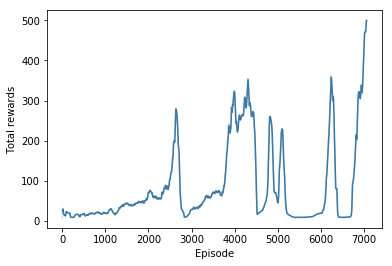

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

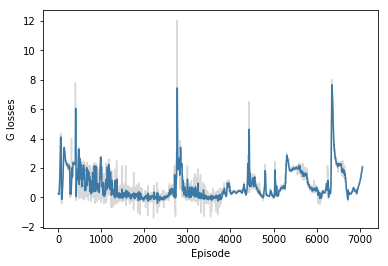

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

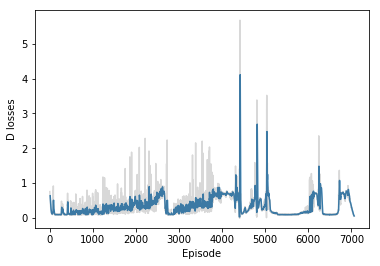

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [108]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.